# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
from tsnn.tstorch import transformers
import torch.nn.functional as F
import math
from typing import Optional

from torch import nn
device = 'mps'


plt.style.use('ggplot')

In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    T: int = 3000
    n_ts: int = 20
    n_f: int = 20
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.2
    split_shift: float = 0.2
    split_seasonal: float = 0.0
    split_cs: float = 0.2
    split_cs_shift: float = 0.2
    low_corr: float = 0.05
    high_corr: float = 0.1

In [3]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [4]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 364 ms, sys: 68.1 ms, total: 432 ms
Wall time: 66.5 ms


In [5]:
z.get_dataloader()

### Simple benchmarks

In [6]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(z.train)

In [7]:
lasso.score(z.train)

np.float64(0.1022131527103484)

In [8]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(z.train)

In [9]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [10]:
comp.correl(z, mode='train')

In [11]:
comp.correl(z, mode='test')

## Torch benchmarks - narrow matrix (no cross-TS interactions)

### Fully connected

Equivalent to linear regression setup

In [65]:
z.get_dataloader(narrow=True)

In [66]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
                                              )
        
        
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [67]:
m = NeuralNetwork(n_f=Config.n_f).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


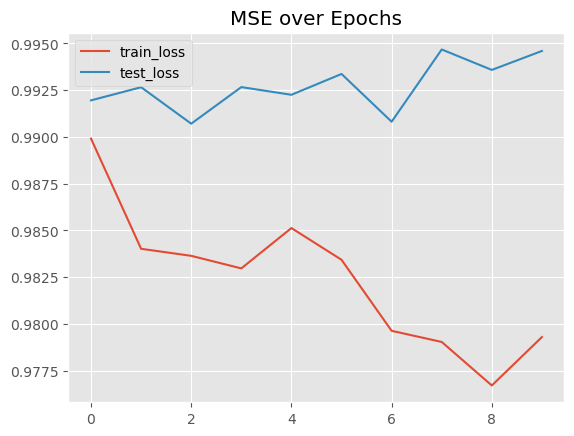

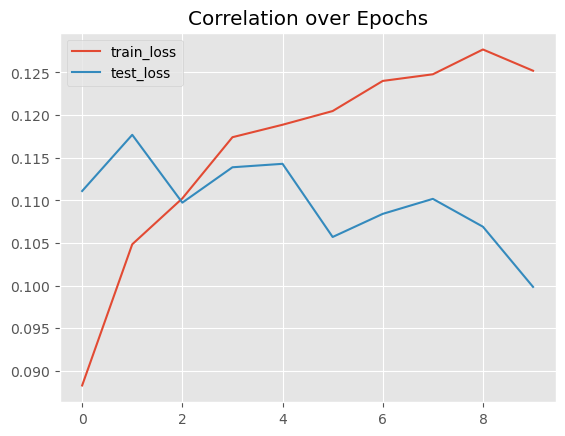

In [68]:
full_nn.fit(z.train, z.test, epochs=10)

In [69]:
comp = benchmark_comparison.Comparator(models=[full_nn, lasso], model_names=['nn', 'lasso'])

In [70]:
comp.correl(z, mode='train')

In [71]:
comp.correl(z, mode='test')

### LSTM

Equivalent to linear regression setup

In [72]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [73]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_f, hidden_dim=32):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_f, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.decoder = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, T=10, n_f)
        _, (h, _) = self.encoder(x)
        out = self.decoder(h[-1]) 
        return out

In [74]:
m = LSTMModel(n_f=Config.n_f).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


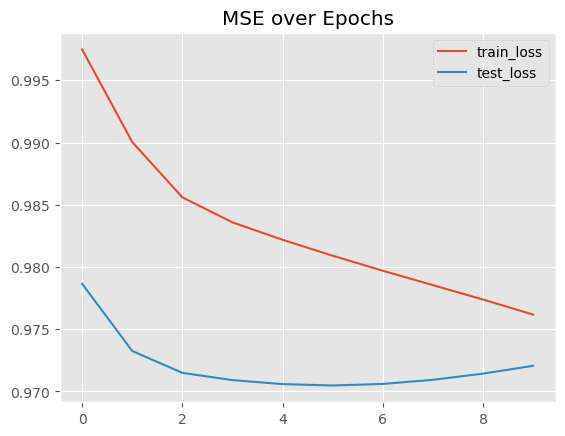

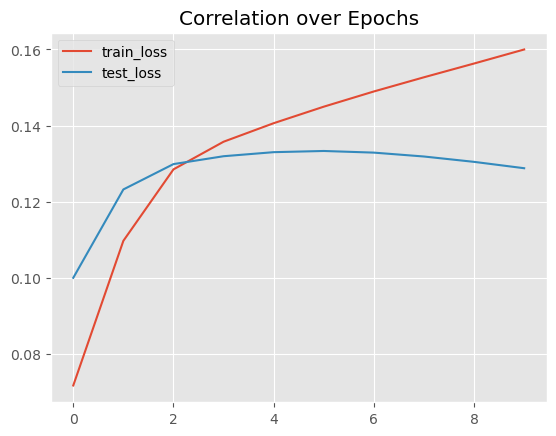

In [75]:
model_lstm.fit(z.train, test=z.test, epochs=10)

In [76]:
comp = benchmark_comparison.Comparator(models=[model_lstm, lasso], model_names=['lstm', 'lasso'])

In [77]:
comp.correl(z, mode='train')

In [78]:
comp.correl(z, mode='test')

### Transformer

In [79]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [80]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_f, n_rolling, d_model=64, nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.input_dim = n_f
        self.d_model = d_model

        # Linear projection of n_f features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_f)
        # print(x.shape)
        B, n_rolling, n_f = x.shape

        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, src_key_padding_mask=mask, mask=causal_mask)

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        
        # encoded = self.encoder(x, mask=causal_mask)#[: x.size(1), : x.size(1)])
        # out = self.decoder(encoded[:, -1, :]).squeeze(-1)
        # print(out.shape)
        # 1/0
        return out.reshape((-1, 1))

In [81]:
m = TransformerEncoderModel(Config.n_f, 5).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/it]


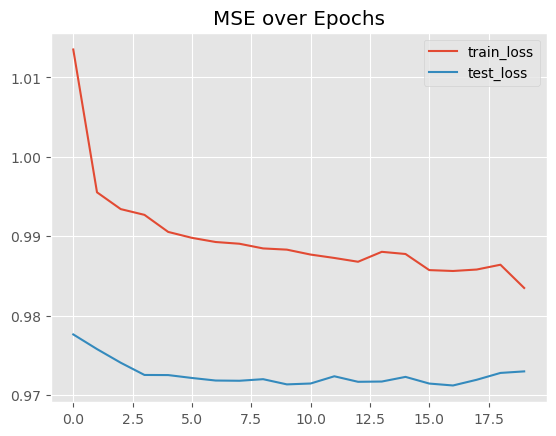

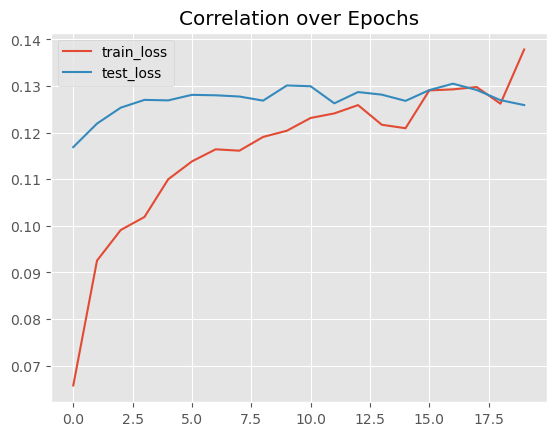

In [82]:
model_torch.fit(z.train, test=z.test, epochs=20)

In [83]:
comp = benchmark_comparison.Comparator(models=[model_torch, lasso], model_names=['transformer', 'lasso'])

In [84]:
comp.correl(z, mode='train')

In [85]:
comp.correl(z, mode='test')

## Torch benchmarks - wide matrix (cross-TS interactions)

### Fully connected

In [86]:
z.get_dataloader()

In [87]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(n_ts*n_f, 512),
        #     nn.ReLU(),
        #     # nn.Linear(512, 512),
        #     # nn.ReLU(),
        #     nn.Linear(512, n_ts),
        # )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [88]:
m = NeuralNetwork(n_ts=Config.n_ts, n_f=Config.n_f).to(device)
# optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)#, weight_decay=1e-2)
optimizer = torch.optim.AdamW(m.parameters(), lr=5e-2, weight_decay=1e-2)
optimizer = torch.optim.SGD(m.parameters(), lr=2e-3)#AdamW(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.11it/s]


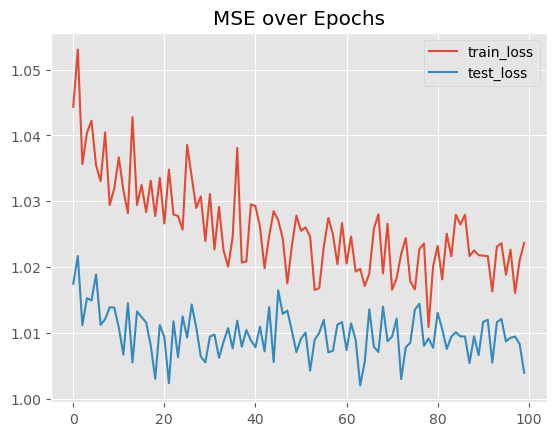

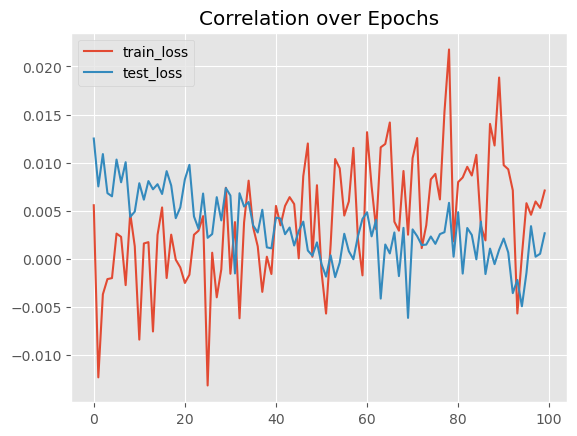

In [89]:
full_nn.fit(z.train, z.test, epochs=100)

In [90]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [91]:
comp.correl(z, mode='train')

In [92]:
comp.correl(z, mode='test')

### LSTM model with 10 timestamps

In [93]:
z.get_dataloader(n_rolling=10, batch_size=1024)

In [94]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [95]:
m = LSTMModel(n_ts=Config.n_ts, n_f=Config.n_f, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.30it/s]


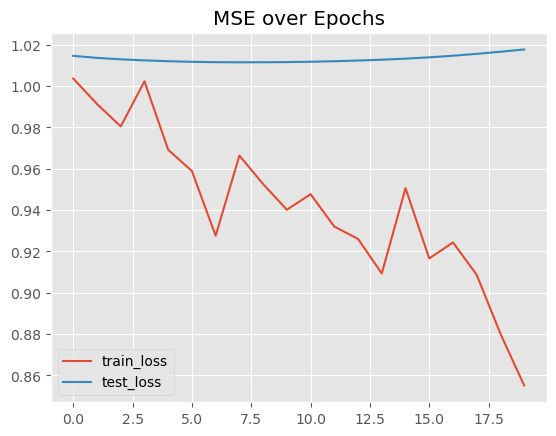

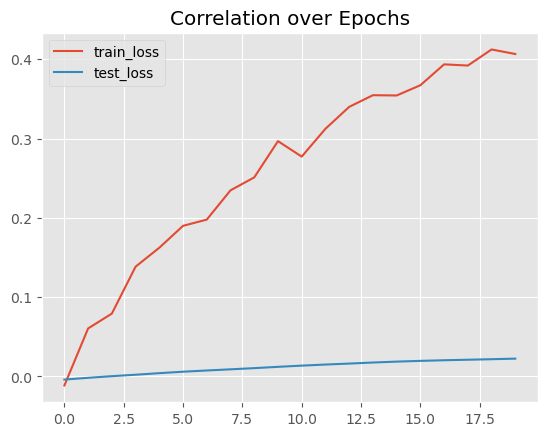

In [96]:
model_lstm.fit(z.train, test=z.test, epochs=20)

In [97]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [98]:
comp.correl(z, mode='train')

In [99]:
comp.correl(z, mode='test')

### Transformer

In [168]:
z.get_dataloader(n_rolling=10, roll_y=False)

In [169]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [170]:
def custom_loss(a, b):
    return 1 - torch.corrcoef(a, b)

In [171]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


# model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, loss_fn=nn.L1Loss())
model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, loss_fn=nn.HuberLoss())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


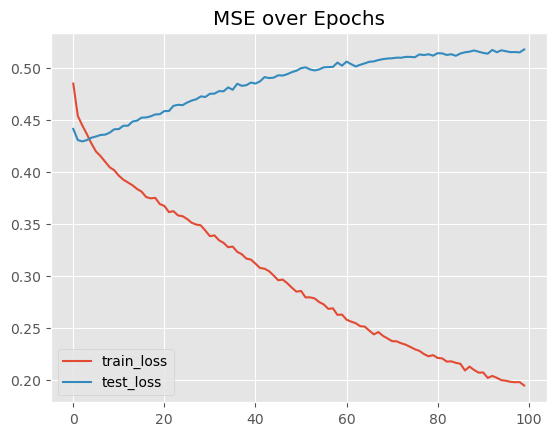

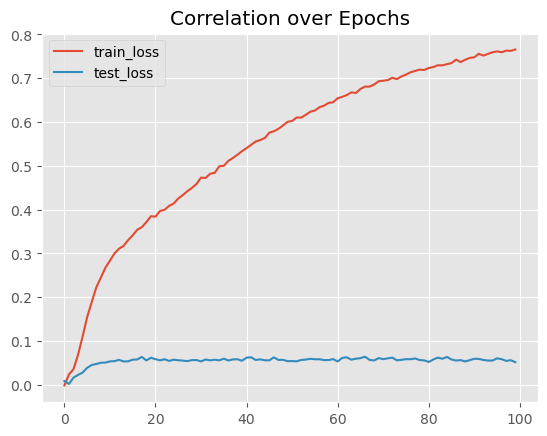

In [172]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [173]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [174]:
comp.correl(z, mode='train')

In [175]:
comp.correl(z, mode='test')

### Re-writing the transformer and checking that we get the same results

In [185]:
z.get_dataloader(n_rolling=5)

In [186]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return (q_idx == kv_idx) | (q_idx == 4) & (kv_idx == 3)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [187]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

In [188]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.mask = mask
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [189]:
mask = causal_mask
mask = build_attention_mask(mask, 5, device=device)

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 5, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


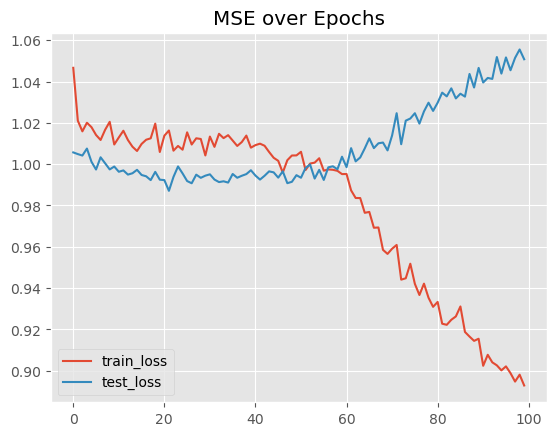

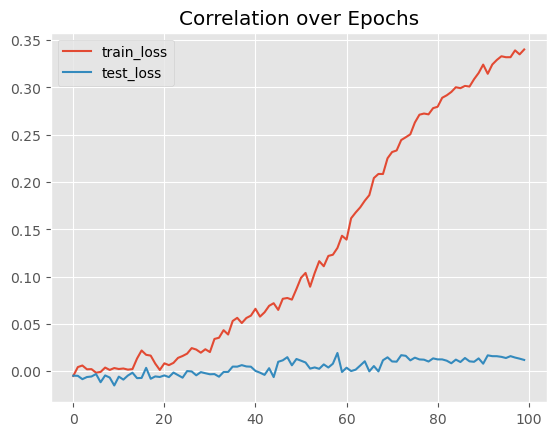

In [190]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [191]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [183]:
comp.correl(z, mode='train')

In [184]:
comp.correl(z, mode='test')

### Transformer with multi-step

In [216]:
z.get_dataloader(n_rolling=5, roll_y=True)

In [217]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return (q_idx == kv_idx) | (q_idx == 4) & (kv_idx == 3)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [218]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

In [219]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.mask = mask
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, :, :])  # (B, N)
        return out

In [220]:
mask = causal_mask
mask = build_attention_mask(mask, 5, device=device)

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 5, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]
Traceback (most recent call last):
  File "/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


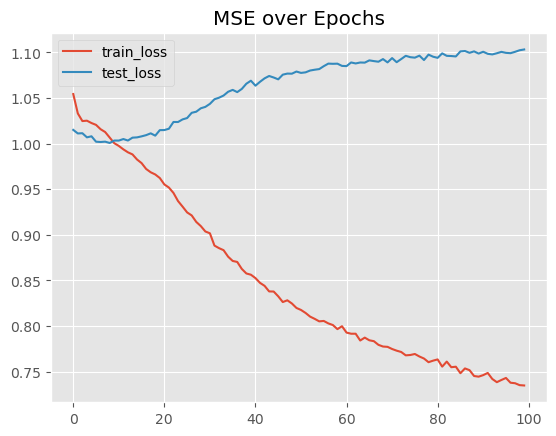

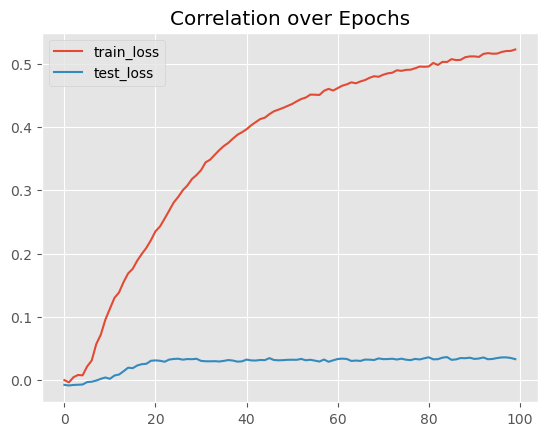

In [221]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [222]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [223]:
comp.correl(z, mode='train')

UserWarning: data dimension mismatch for model transformer, the dataloader object must match the prediction model

In [ ]:
comp.correl(z, mode='test')

### Example of attention deterministic sparsity

In [117]:
z.get_dataloader(n_rolling=10)

##### Rolling mask

In [118]:
def generate_sliding_window(window_size: int) -> _mask_mod_signature:
    def sliding_window(b, h, q_idx, kv_idx):
        return q_idx - kv_idx <= window_size

    sliding_window_mask = and_masks(sliding_window, causal_mask)
    sliding_window_mask.__name__ = f"sliding_window_{window_size}"
    return sliding_window_mask



mask_fn = generate_sliding_window(window_size=2)
plot_mask(mask_fn, seq_len=10)

In [119]:
mask = generate_sliding_window(2)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.21it/s]


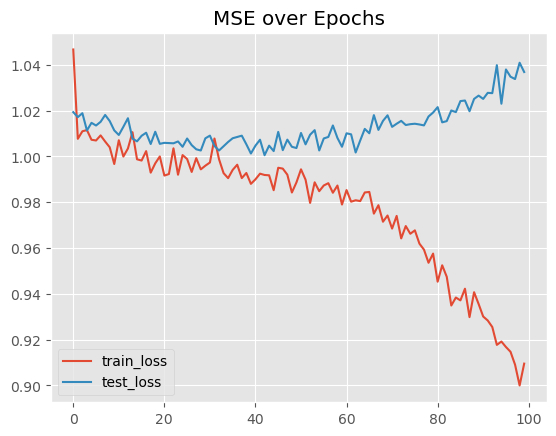

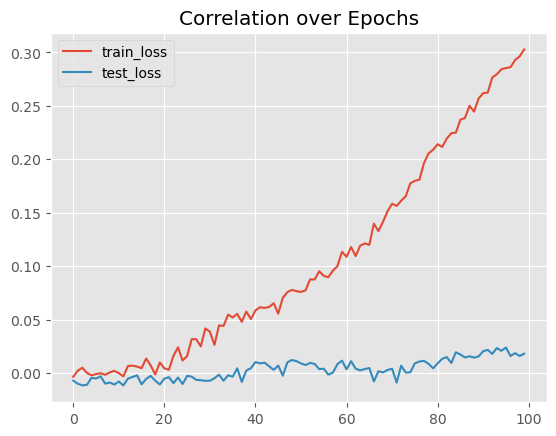

In [120]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [121]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [122]:
comp.correl(z, mode='train')

In [123]:
comp.correl(z, mode='test')

##### Dilation mask

In [124]:
def generate_dilated(dilation: int) -> _mask_mod_signature:
    def dilated_sliding_window(b, h, q_idx, kv_idx):
        diff = torch.abs(q_idx - kv_idx)
        is_dilated = (diff % dilation) == 0
        # is_dilated = diff == 0
        return is_dilated
    
    dilated_sliding_window_mask = and_masks(causal_mask, dilated_sliding_window)
    dilated_sliding_window_mask.__name__ = f"dilation_{dilation}"
    return dilated_sliding_window_mask

mask_fn = generate_dilated(3)
plot_mask(mask_fn, seq_len=10)

In [125]:
mask = generate_dilated(dilation=3)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


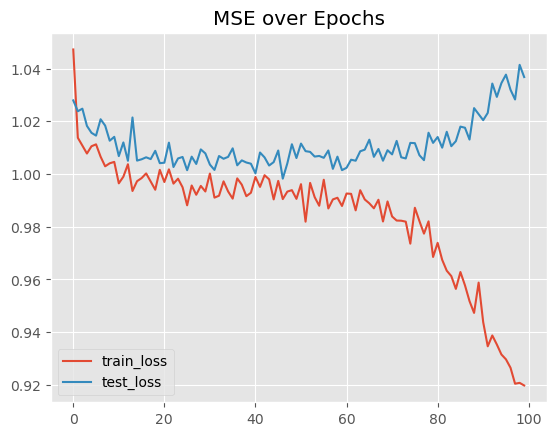

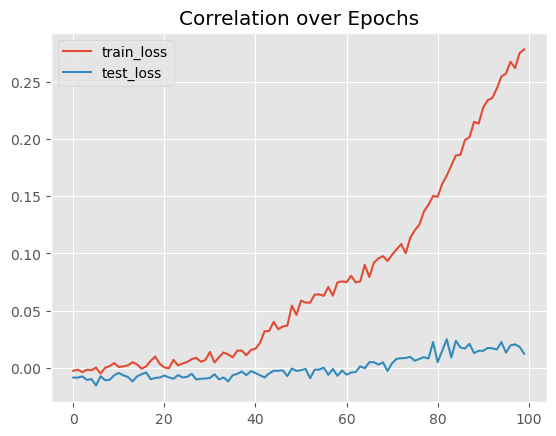

In [126]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [127]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [ ]:
comp.correl(z, mode='train')

In [ ]:
comp.correl(z, mode='test')

##### Dilation mask combined with rolling

In [ ]:
def dilation_rolling(dilation: int, window: int) -> _mask_mod_signature:
    return or_masks(generate_dilated(dilation), generate_sliding_window(window))

mask_fn = dilation_rolling(dilation=3, window=3)
plot_mask(mask_fn, seq_len=10)

In [ ]:
mask = dilation_rolling(dilation=3, window=2)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [ ]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [ ]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [ ]:
comp.correl(z, mode='train')

In [ ]:
comp.correl(z, mode='test')

## Sparse Attention

In [12]:
z.get_dataloader(n_rolling=10)

In [13]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return q_idx >= (kv_idx+100)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [14]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

In [15]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5, attn_l1_coeff=0, sparsify=None):
        super().__init__()
        self.mask = mask
        self.sparsify = sparsify
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask, sparsify=self.sparsify)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [16]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_causal = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.26it/s]


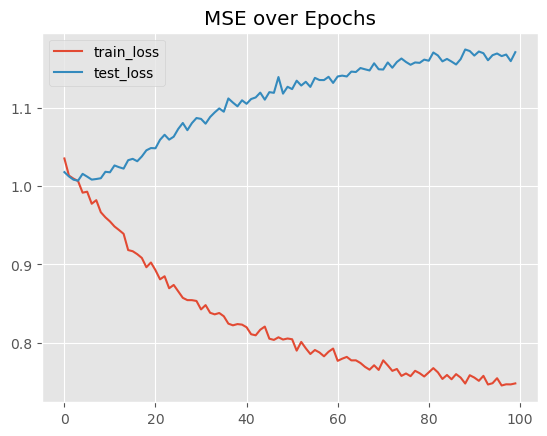

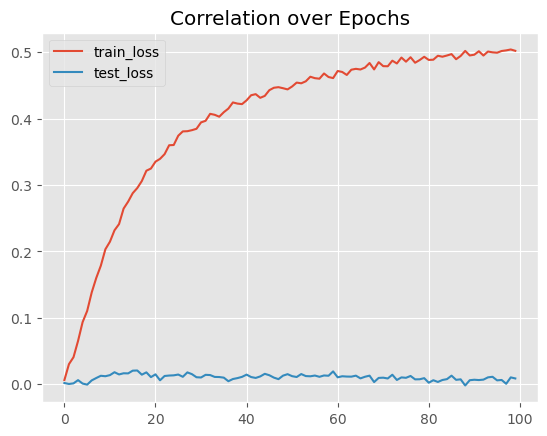

In [17]:
model_causal.fit(z.train, test=z.test, epochs=100)

In [90]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [91]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_sparse = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s]


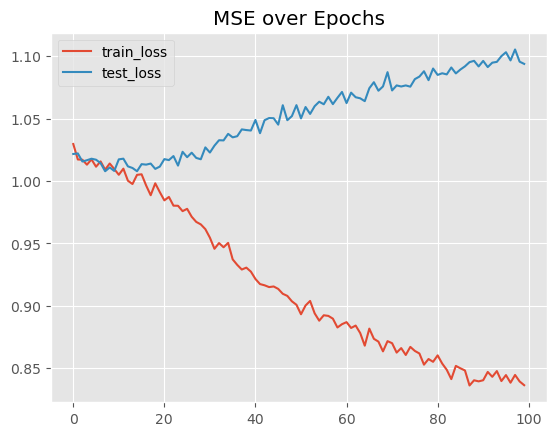

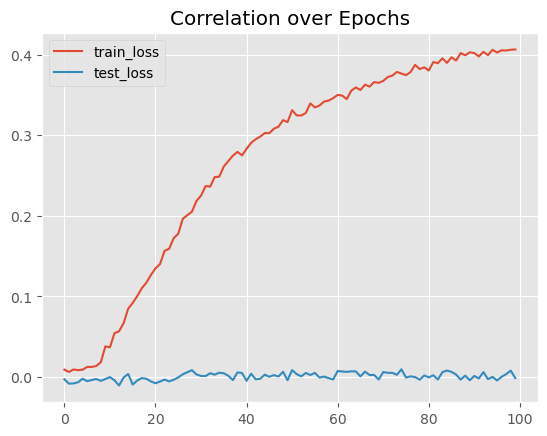

In [92]:
model_sparse.fit(z.train, test=z.test, epochs=100)

In [93]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_causal, model_sparse], model_names=['lasso', 'lr', 'causal', 'sparse'])

In [94]:
comp.correl(z, mode='train')

In [95]:
comp.correl(z, mode='test')

## Dual attention transformer with sparsity and custom mask

In [80]:
z.get_dataloader(n_rolling=10)

In [81]:

# Transformer model with both TS then CS attention.

class DualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,          # number of time series (N)
        n_f,           # number of input features per timestamp
        n_rolling,     # lookback window length (T)
        mask,
        d_model=128,
        nhead_time=8,      # heads for temporal attention (stage 1)
        nhead_series=8,    # heads for cross-series attention (stage 2)
        num_layers_time=1,
        num_layers_series=1,
        dim_feedforward=512,
        dropout=0.8,
        sparsify=None
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        self.mask = mask
        self.sparsify = sparsify
        # ------------------------------------------------------------------
        # 1. Input projection: (n_f) → d_model  (shared across all series & timesteps)
        # ------------------------------------------------------------------
        self.input_proj = nn.Linear(n_f, d_model)

        # Positional encoding for the temporal dimension (stage 1)
        self.pos_emb_time = nn.Parameter(torch.randn(1, n_rolling, d_model))
        # self.pos_emb_time = torch.arange(1, n_rolling)

        # ------------------------------------------------------------------
        # Stage 1: Temporal Transformer (attention over time, independent per series)
        # ------------------------------------------------------------------
        temporal_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_time,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            # activation="gelu",
        )
        self.temporal_transformer = transformers.TransformerEncoder(
            temporal_layer, num_layers=num_layers_time
        )

        # ------------------------------------------------------------------
        # Stage 2: Cross-Series Transformer (attention over the N series)
        # ------------------------------------------------------------------
        series_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_series,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            # activation="gelu",
        )
        self.series_transformer = transformers.TransformerEncoder(
            series_layer, num_layers=num_layers_series
        )

        # Optional positional encoding for the series dimension
        # (can be learned or fixed; here learned)
        
        self.pos_emb_series = nn.Parameter(torch.randn(1, n_ts, d_model))
        # self.pos_emb_series = torch.arange(1, n_ts)

        # ------------------------------------------------------------------
        # Final prediction head: d_model → 1 (forecast scalar per series)
        # ------------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, n_rolling, n_ts, n_f)   float tensor
        Returns: (B, n_ts)               predicted scalar for each series
        """
        B, T, N, F = x.shape  # T = n_rolling, N = n_ts, F = n_f

        # ------------------------------------------------------------------
        # 1. Project features → d_model
        # ------------------------------------------------------------------
        # (B, T, N, F) → (B, T, N, d_model)
        x = self.input_proj(x)

        # ------------------------------------------------------------------
        # 2. Reshape so that batch × series becomes the new "batch"
        #    → (B*N, T, d_model)
        # ------------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T, self.d_model)  # (B*N, T, d_model)

        # Add temporal positional encoding
        x = x + self.pos_emb_time[:, :T, :]

        # ------------------------------------------------------------------
        # 3. Temporal Transformer (causal attention over time)
        # ------------------------------------------------------------------
        # x = self.temporal_transformer(x, mask=self.causal_mask_time)  # (B*N, T, d_model)
        x = self.temporal_transformer(x, mask=self.mask, sparsify=self.sparsify)  # (B*N, T, d_model)

        # Take the last timestep representation
        x_last = x[:, -1, :]  # (B*N, d_model)

        # ------------------------------------------------------------------
        # 4. Reshape back to have series dimension explicit
        #    → (B, N, d_model)
        # ------------------------------------------------------------------
        x_series = x_last.view(B, N, self.d_model)

        # Add series positional encoding
        x_series = x_series + self.pos_emb_series

        # ------------------------------------------------------------------
        # 5. Cross-Series Transformer (full attention over the N series)
        # ------------------------------------------------------------------
        # No mask needed here → full bidirectional attention across series
        x_series = self.series_transformer(x_series, sparsify=self.sparsify)  # (B, N, d_model)

        # ------------------------------------------------------------------
        # 6. Final prediction
        # ------------------------------------------------------------------
        out = self.output_head(x_series)      # (B, N, 1)
        out = out.squeeze(-1)                 # (B, N) = (B, n_ts)

        return out

In [82]:
class AlternatingDualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        mask,
        d_model=128,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
        sparsify=None
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts
        self.mask = mask
        self.sparsify = sparsify

        self.input_proj = nn.Linear(n_f, d_model)

        # Broadcasted positional embeddings
        self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))

        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList()
        for _ in range(num_layers):
            temp = transformers.TransformerEncoder(
                transformers.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout),
                num_layers=1
            )
            # we only use the self_attn module from this one — series attention is custom
            series = transformers.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
            self.blocks.append(nn.ModuleDict({
                'temporal': temp,
                'series': series,
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
            }))

        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def series_attention(self, x, attn_layer):
        """
        x: (B, T, N, d)
        Applies attention independently for each (B, T) window over the N dimension.
        """
        B, T, N, D = x.shape

        x_flat = x.view(B*T, N, D)

        out = attn_layer.self_attn(x_flat, x_flat, x_flat,)

        out = out.view(B, T, N, D)
        return out
    
    def temporal_attention(self, x, attn_encoder):
        """
        x: (B, T, N, D)
        Applies temporal attention independently for each series (N dimension)
        using the stored TransformerEncoder.
        """
        B, T, N, D = x.shape
        x_flat = x.transpose(1, 2).contiguous().view(B*N, T, D)

        out = attn_encoder(x_flat, mask=self.mask, sparsify=self.sparsify)

        out = out.view(B, N, T, D).transpose(1, 2)
        return out

    def forward(self, x):
        B, T, N, _ = x.shape

        x = self.input_proj(x)

        # broadcast positional embeddings
        x = x + self.pos_emb_time + self.pos_emb_series

        for block in self.blocks:
            # temporal
            res = x
            x_t = self.temporal_attention(x, block['temporal'])
            x = block['norm1']((res + self.dropout(x_t)).contiguous())

            # series
            res = x
            x_s = self.series_attention(x, block['series'])
            x = block['norm2']((res + self.dropout(x_s)).contiguous())

        # final timestep → (B, N, d)
        x = x[:, -1, :, :]

        return self.output_head(x).squeeze(-1)

In [256]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=3):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [257]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_causal = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


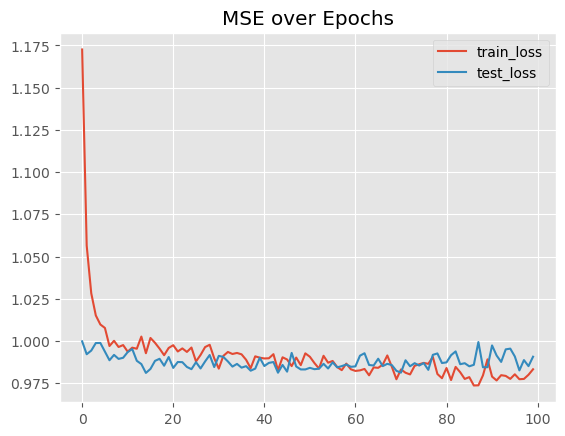

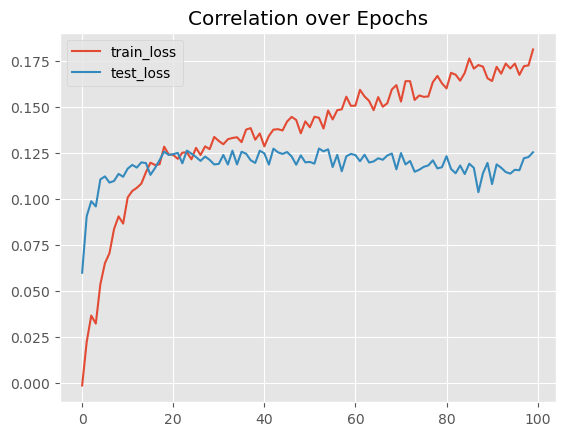

In [258]:
model_causal.fit(z.train, test=z.test, epochs=100)

In [62]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_causal], model_names=['lasso', 'lr', 'causal'])

In [63]:
comp.correl(z, mode='train')

In [64]:
comp.correl(z, mode='test')

## Noise checks 

In [16]:
from tsnn.tstorch import models

In [17]:
models_linear = {'lasso': ml_benchmarks.LassoBenchmark()}

In [18]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)

In [19]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=3):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


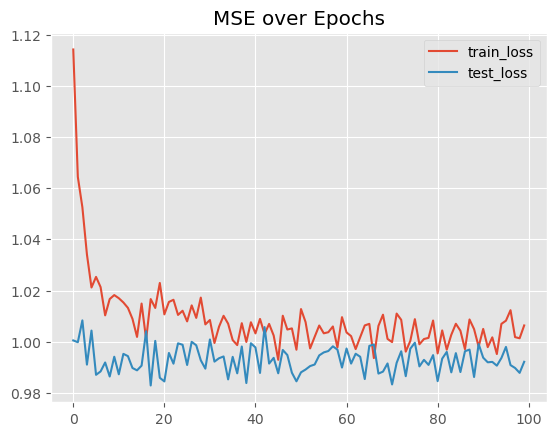

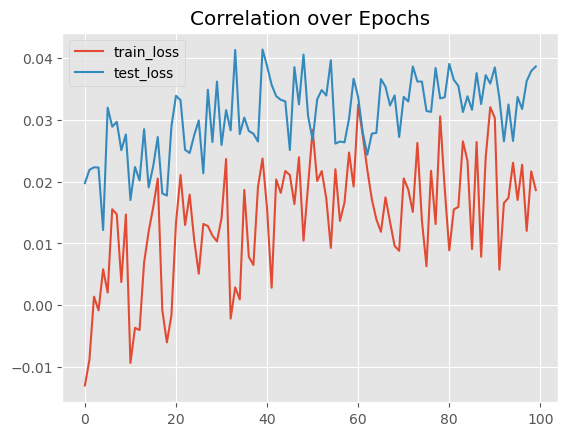

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


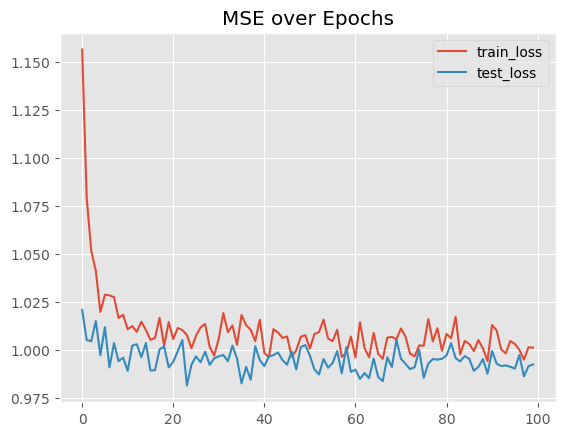

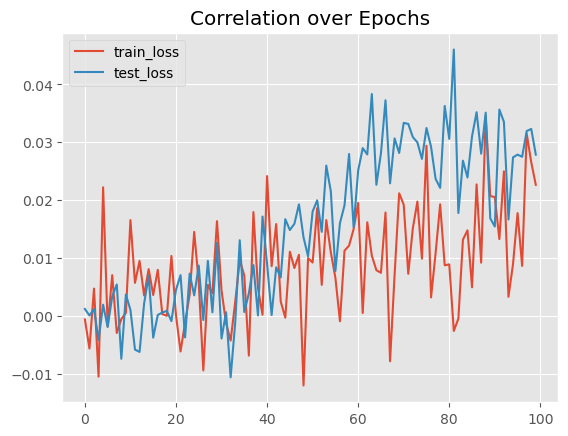

In [19]:
for c in [
    # 0.1, 
          # 0.05, 0.03, 
          0.01]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
                                                                    dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     # optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=0.001)
                                                      optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.01)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=100)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.91s/it]


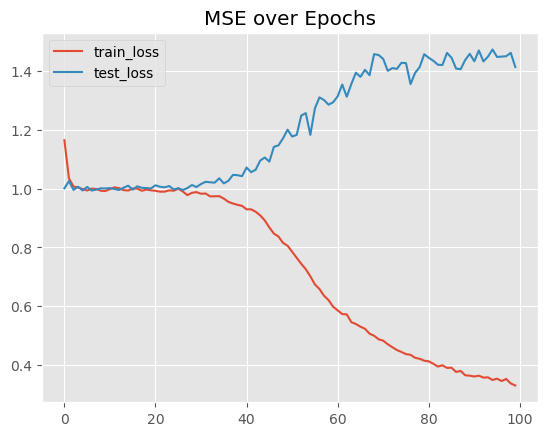

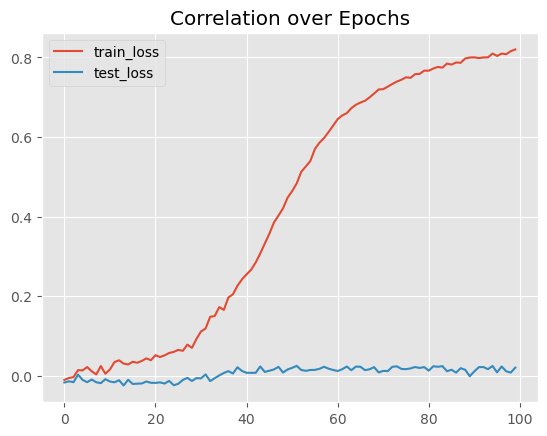

In [34]:
for c in [
    # 0.1, 
          # 0.05, 0.03, 
          0.03]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 1.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.2, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=0.001)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.05)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=100)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


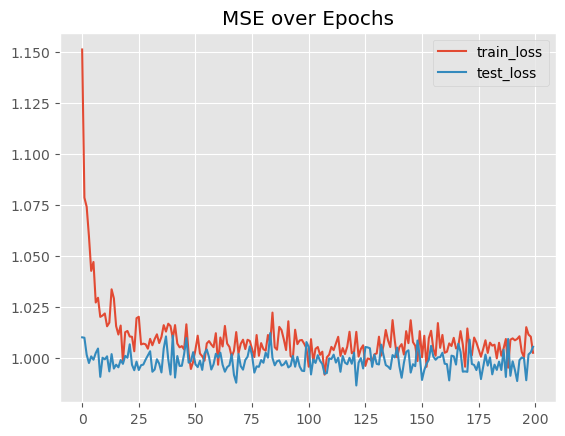

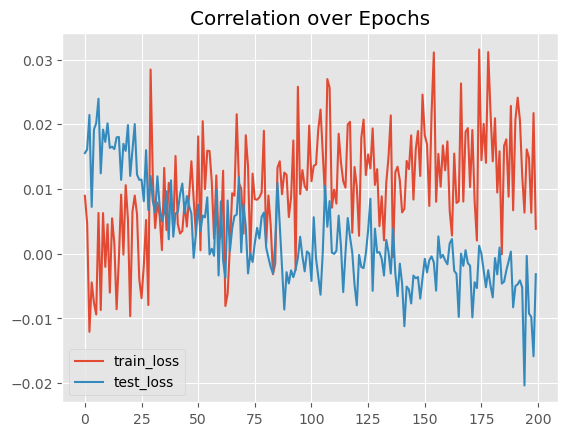

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:28<00:00,  1.64s/it]


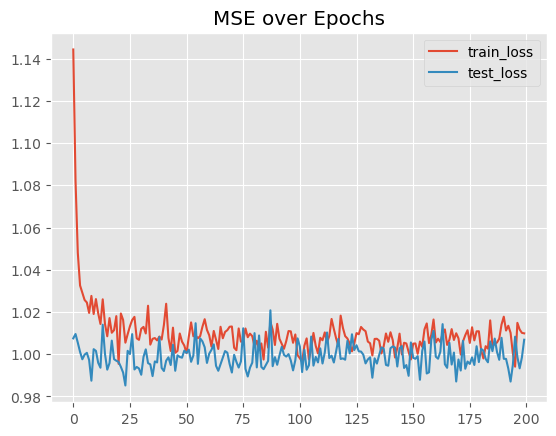

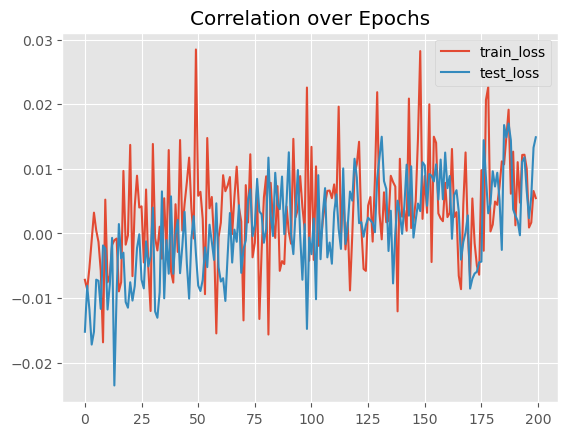

In [23]:
for c in [
    # 0.1, 
          # 0.05, 0.03, 
          0.01]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 1.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
                                                                    dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     # optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=0.001)
                                                      optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.01)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=200)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


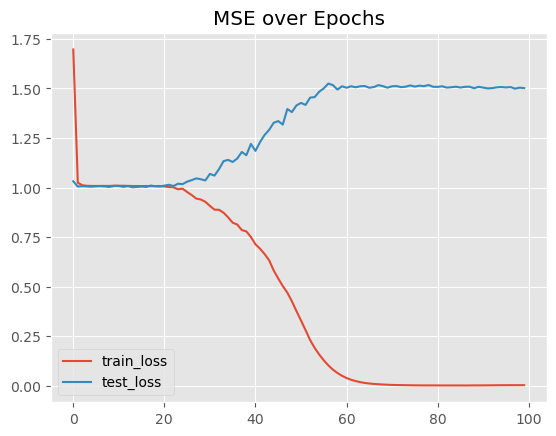

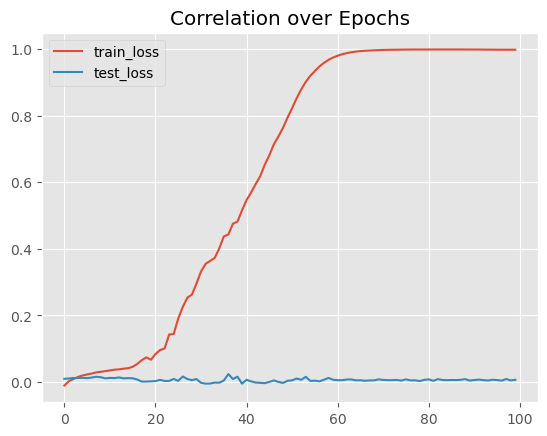

python(95686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(95690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [87]:
for c in [
    0.07, 
          # 0.05, 0.03, 
          # 0.01
]:
    @dataclass
    class Config:
        T: int = 4000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 1.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()#batch_size=1024)
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.0, dim_feedforward=64, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=5e-3, weight_decay=1e-2)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.05, momentum=0.1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=100)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


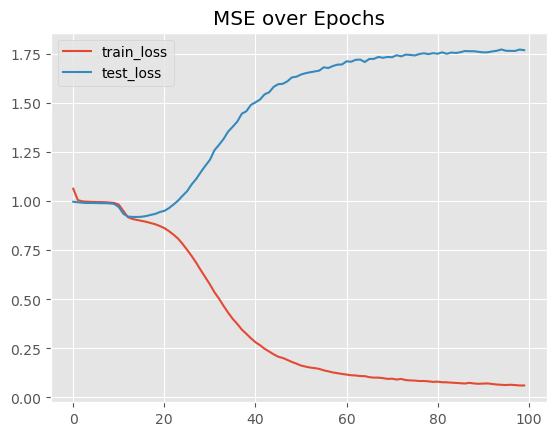

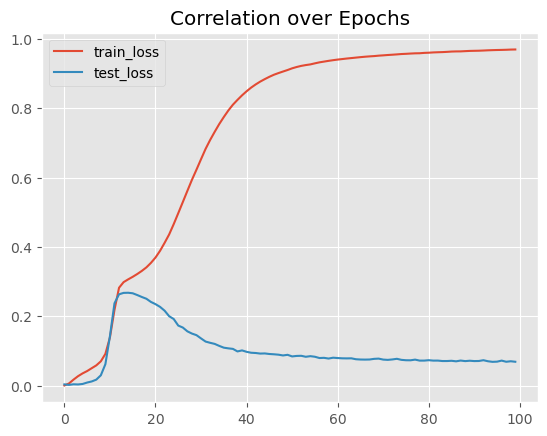

python(4895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(4907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [103]:
for c in [
    0.1, 
          # 0.05, 0.03, 
          # 0.01
]:
    @dataclass
    class Config:
        T: int = 20000
        n_ts: int = 2
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 1.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()#batch_size=1024)
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.0, d_model=64, dim_feedforward=64*4, sparsify=None, 
                                                                           roll_y=True).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3, weight_decay=1e-2)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.05, momentum=0.1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10, roll_y=True, batch_size=256*4)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=100)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.57it/s]


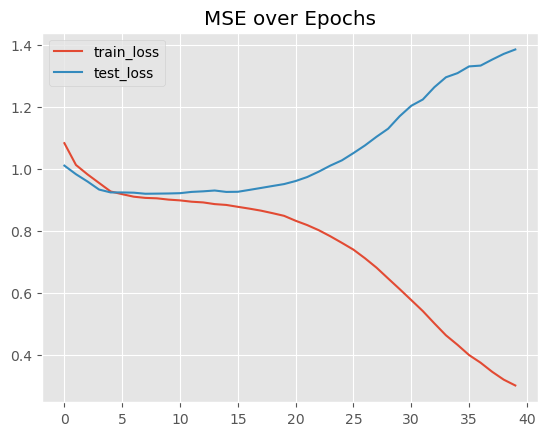

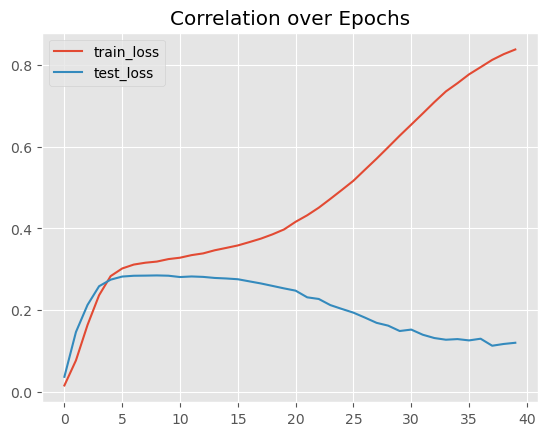

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.72it/s]


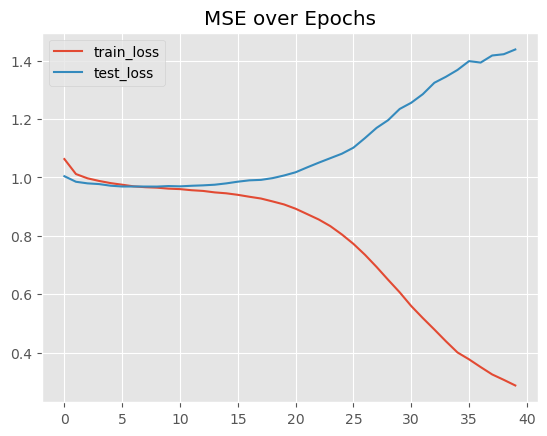

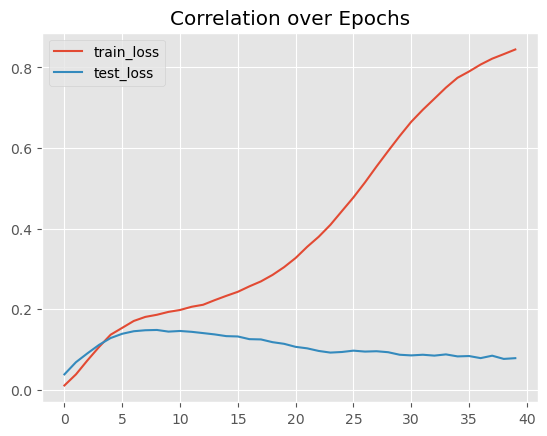

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.70it/s]


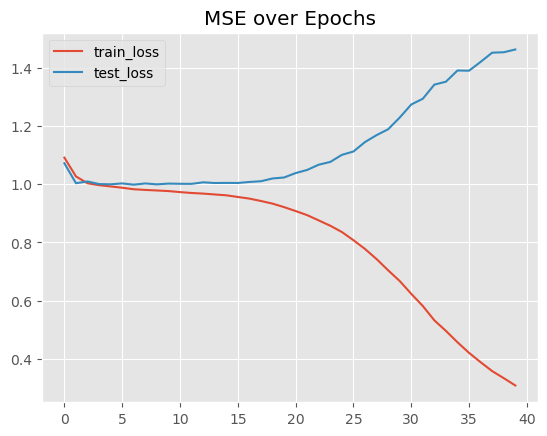

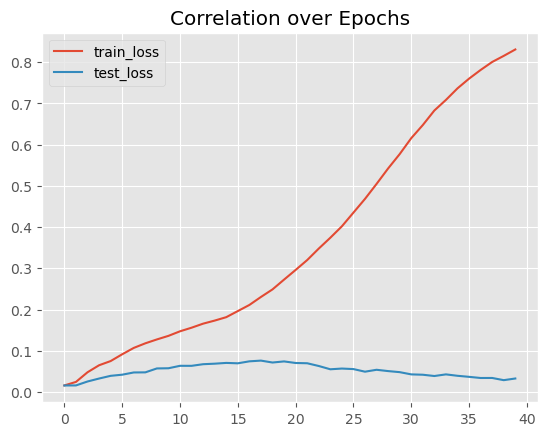

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.74it/s]


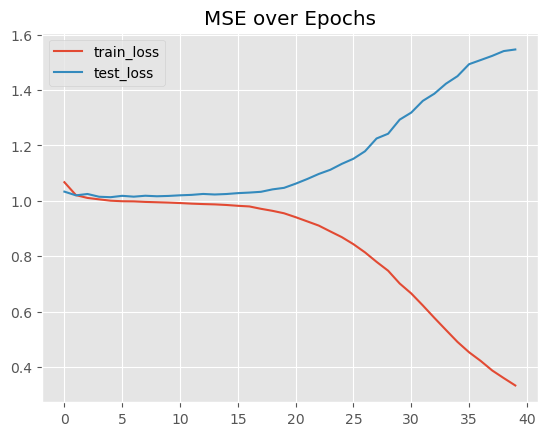

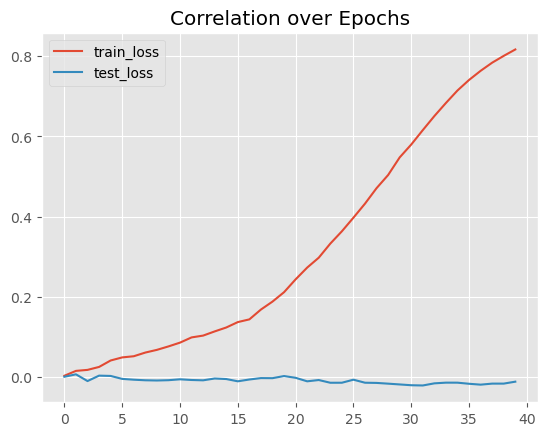

In [22]:
for c in [
    0.1, 
          0.05, 0.03, 
          0.01
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 2
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 1.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=True).to(device),
        # 'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
        #                                                             dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
        #                                                                    roll_y=True).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/2, weight_decay=0)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10, roll_y=True, batch_size=256*2)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=40)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:43<00:00,  2.59s/it]


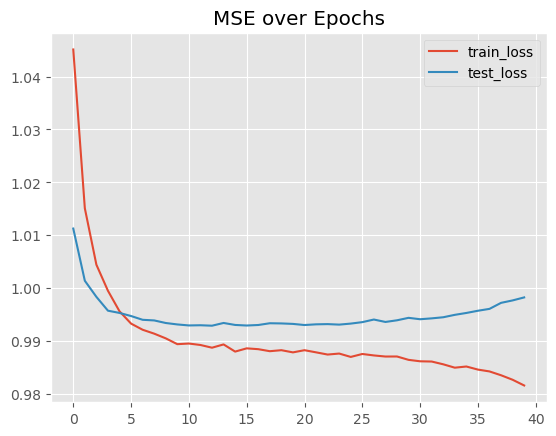

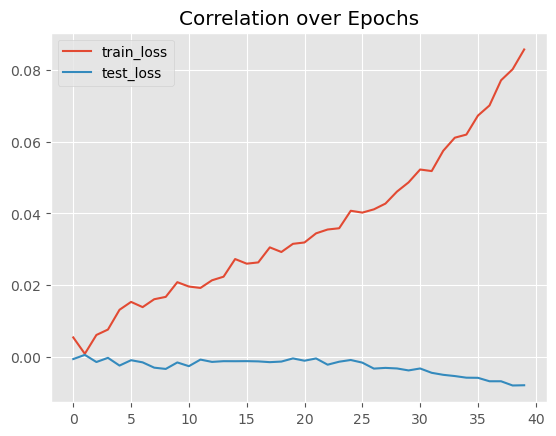

python(8674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(8683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [23]:
models_torch = {
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=64, dim_feedforward=64*4, sparsify=None, 
                                                                           roll_y=True).to(device),
               }

models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                 optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/4, weight_decay=0)
                                                  # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                ) for k in models_torch}


z.get_dataloader(n_rolling=10, roll_y=True, batch_size=256)
for k in models_torch:
    models_torch[k].fit(z.train, test=z.test, epochs=40)


comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                       model_names=[k for k in models_linear] + [k for k in models_torch])
display(comp.correl(z, mode='train'))
display(comp.correl(z, mode='test'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:09<00:00,  1.74s/it]


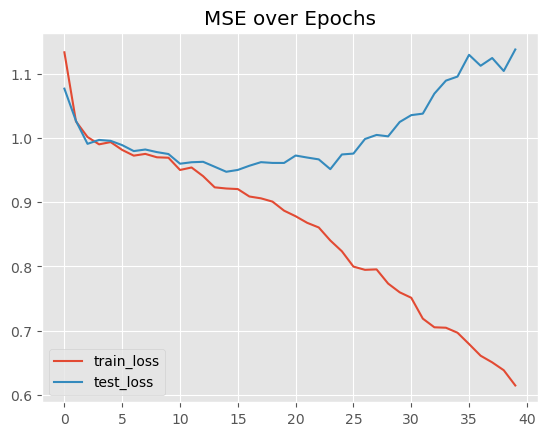

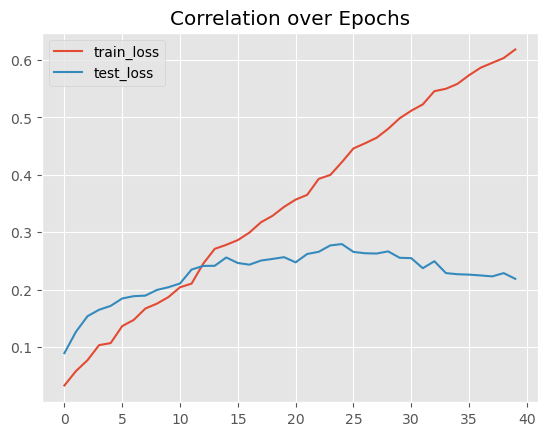

python(86198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(86202) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86203) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86204) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86205) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [51]:
for c in [
    0.1, 
          # 0.05, 0.03, 
          # 0.01
]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.2
        split_shift: float = 0.2
        split_seasonal: float = 0.0
        split_cs: float = 0.2
        split_cs_shift: float = 0.2
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader(batch_size=1024)
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.2, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.01)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=40)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

In [48]:
for c in [
    0.1, 
          # 0.05, 0.03, 
          # 0.01
]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 1.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader(batch_size=1024)
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.2, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.01)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=40)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

  0%|                                                                                                            | 0/40 [00:00<?, ?it/s]


RuntimeError: Tensor for argument weight is on cpu but expected on mps

In [31]:
for c in [0.1, 
          # 0.05, 0.03, 
          0.01]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 1.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    # models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=0.001)) for k in models_torch}
    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=0.001)) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10, batch_size=128)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=200)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

 16%|████████████████▋                                                                                           | 62/400 [01:07<06:07,  1.09s/it]


KeyboardInterrupt: 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


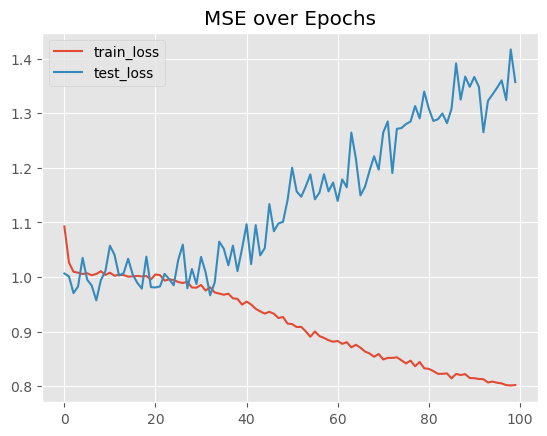

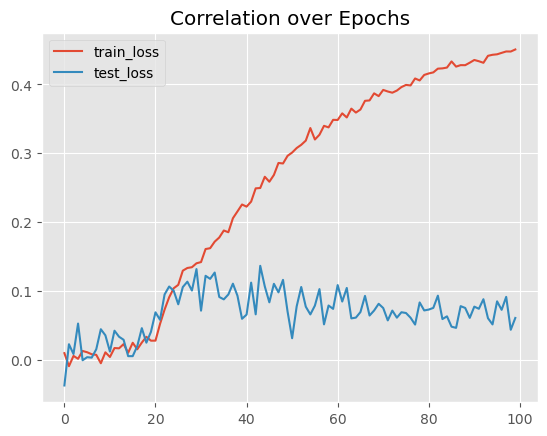

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.27s/it]


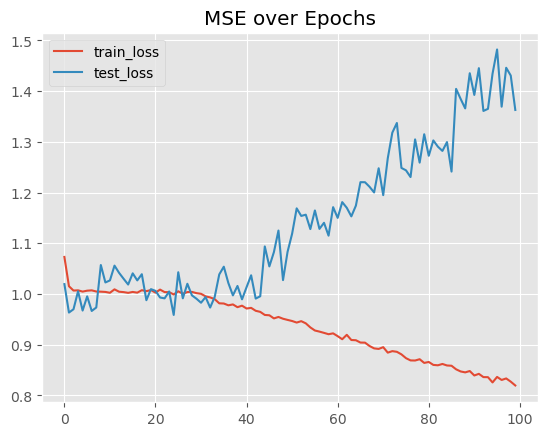

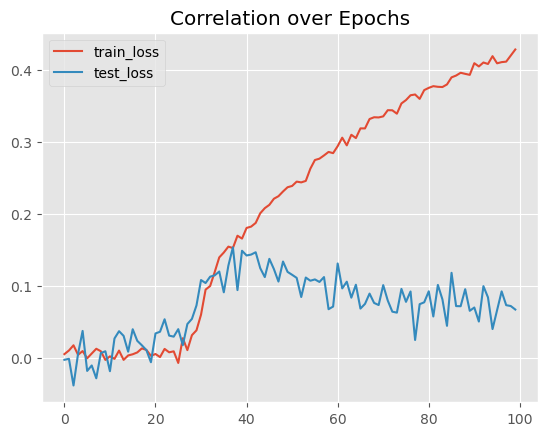

In [27]:
for c in [0.1, 
          # 0.05, 0.03, 
          # 0.01
         ]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 1.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=0.001)) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10, batch_size=128)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=100)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


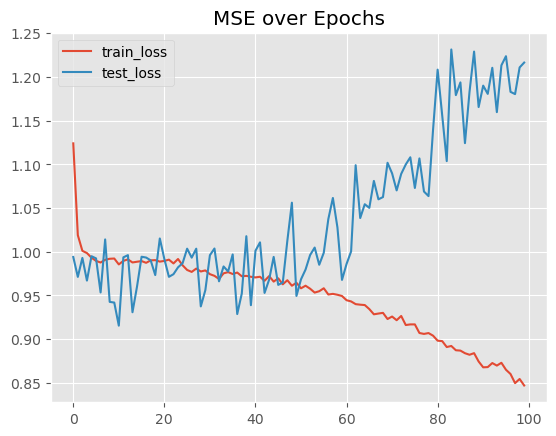

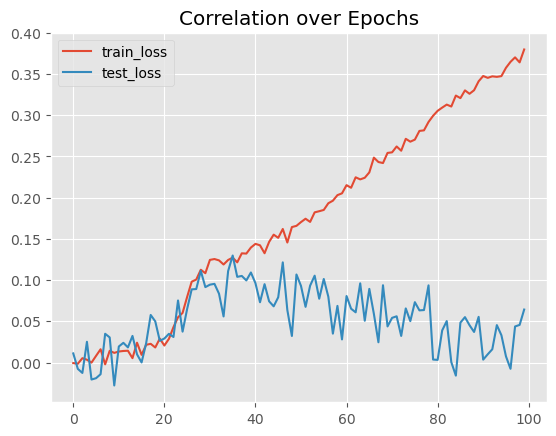

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


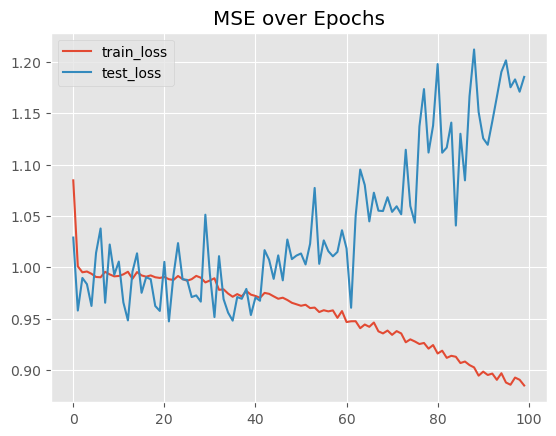

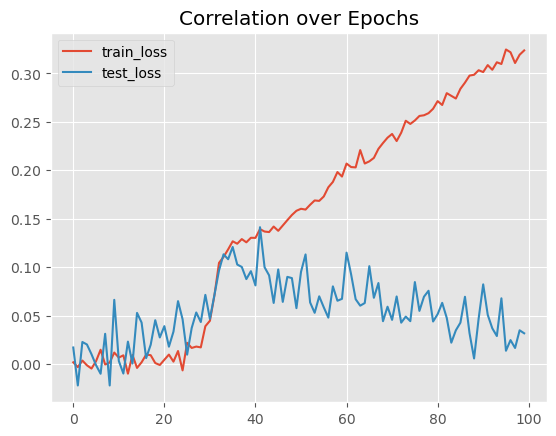

In [28]:
for c in [0.1, 
          # 0.05, 0.03, 
          # 0.01
         ]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 1.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=0.001)) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10, batch_size=128)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=100)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


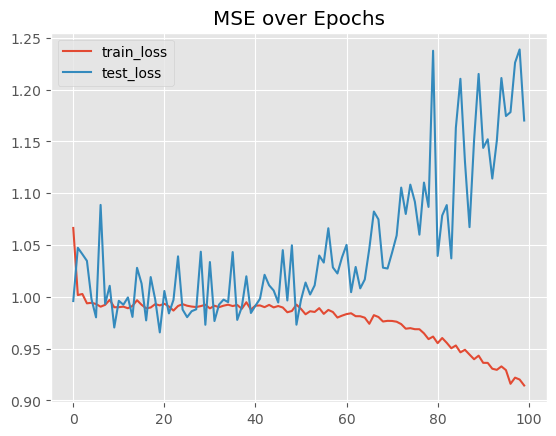

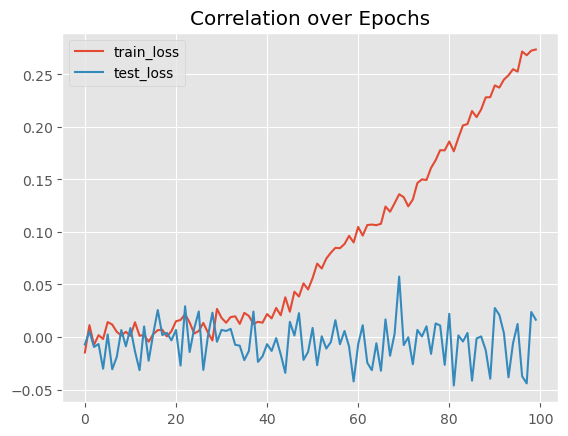

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


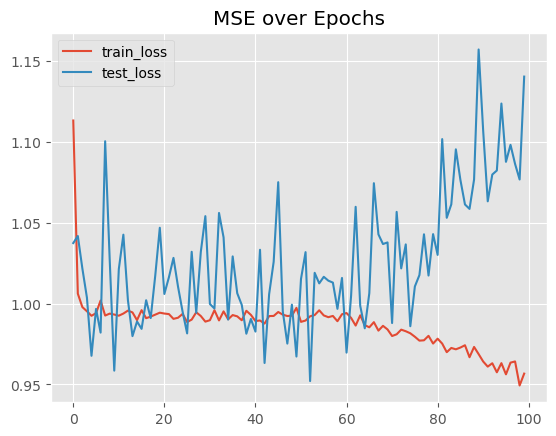

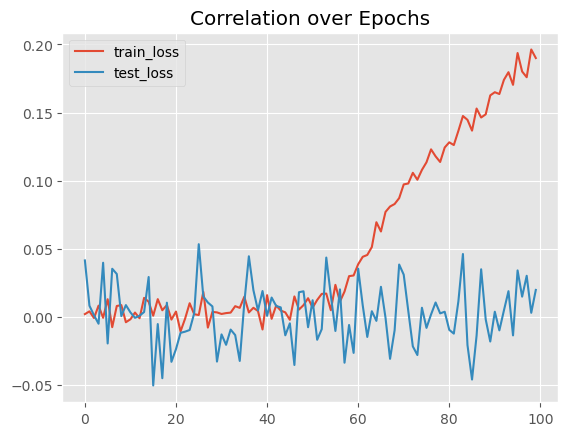

python(58936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [29]:
for c in [0.1, 
          # 0.05, 0.03, 
          # 0.01
         ]:
    @dataclass
    class Config:
        T: int = 3000
        n_ts: int = 10
        n_f: int = 40
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 1.0
        low_corr: float = c
        high_corr: float = c
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)
    
    
    # models_torch = {
    #       'temporal_transformer': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device),
    #       # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
    #       'dual_transformer': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device),
    #       # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       'alternating_transformer': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
    #       # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
    #            }
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TCTC',
                                                                    dropout=0.5, dim_feedforward=256, sparsify=None).to(device),
          # 'alternating_transformer_s': AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=0.001)) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=10, batch_size=128)
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=100)
        
    
        
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

## Noise final

Remarks:
- batch size * k --> lr * k
- n_observation / k --> n_epoch * k (same nb of examples seen)
- n_ts?

### CS effect

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.55s/it]


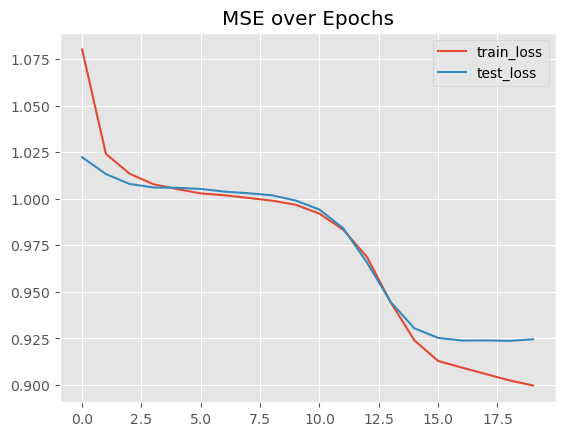

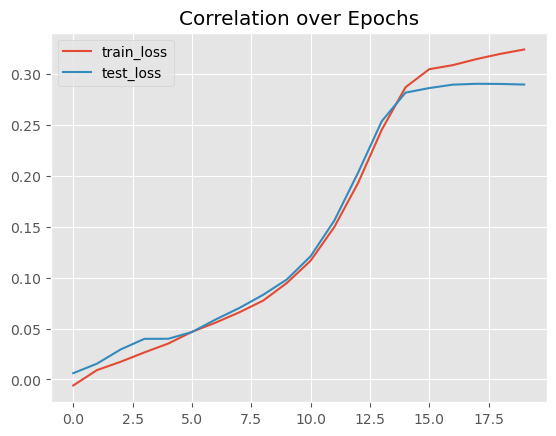

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]


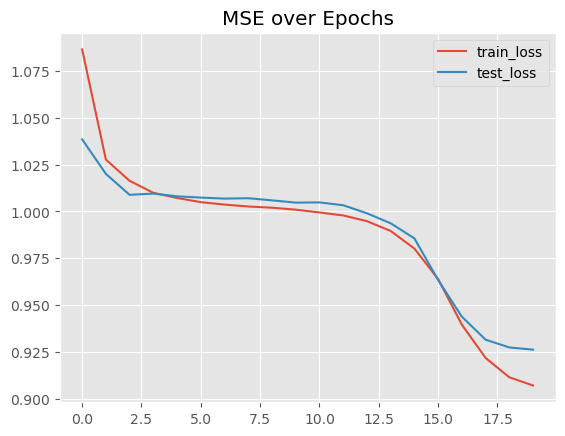

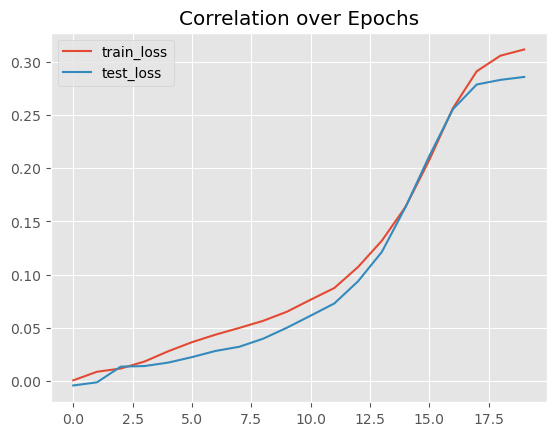

python(14338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14339) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14346) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14348) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(14355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.94s/it]


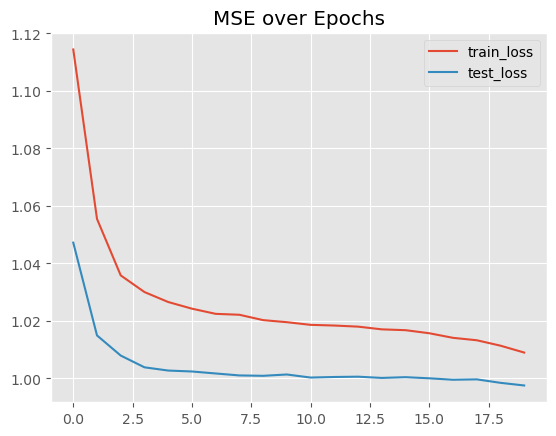

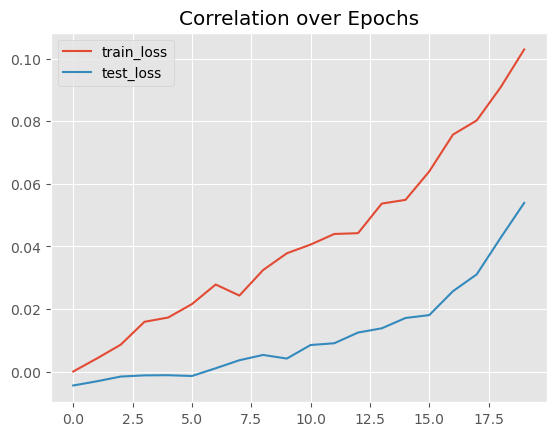

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


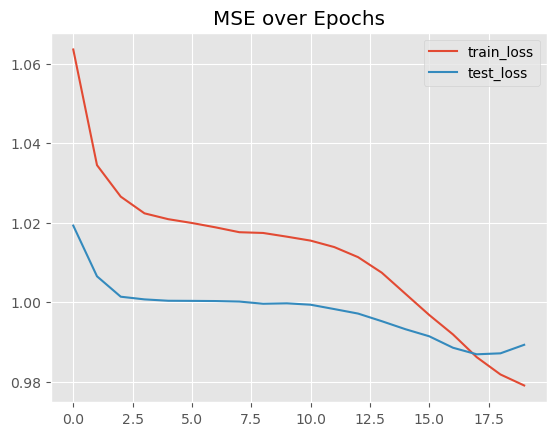

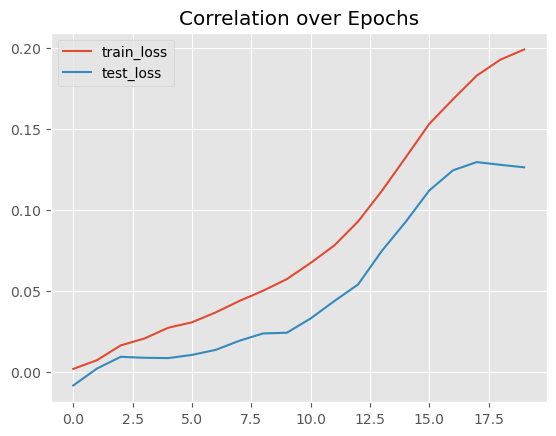

python(14458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(14471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:20<00:00,  2.00s/it]


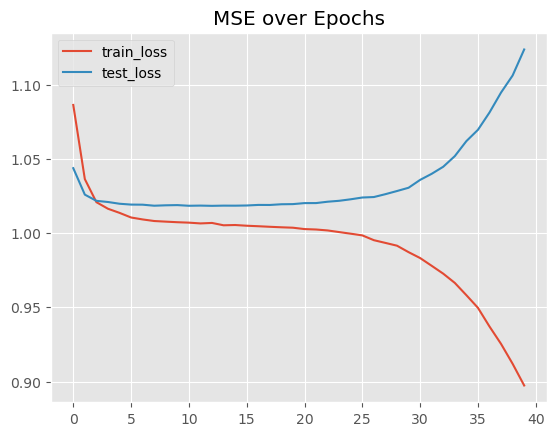

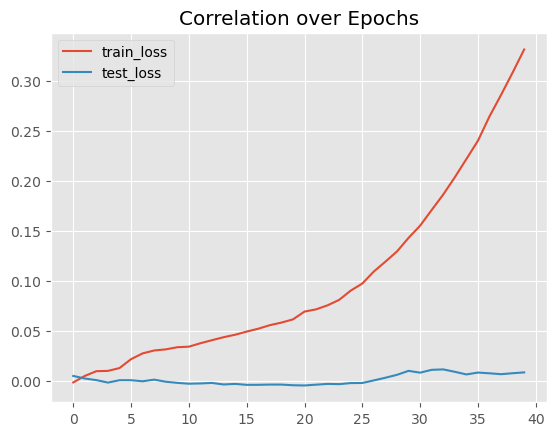

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:19<00:00,  1.98s/it]


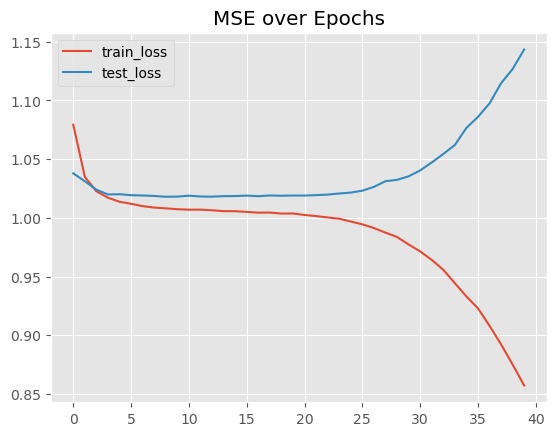

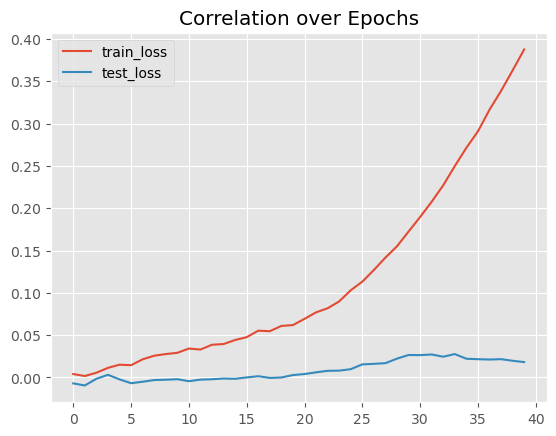

python(14581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14592) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(14595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:01<00:00,  1.53s/it]


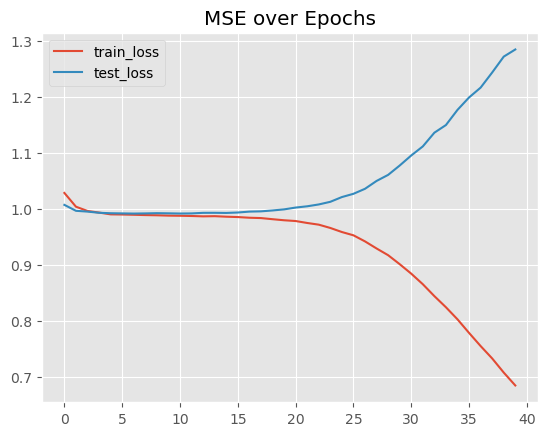

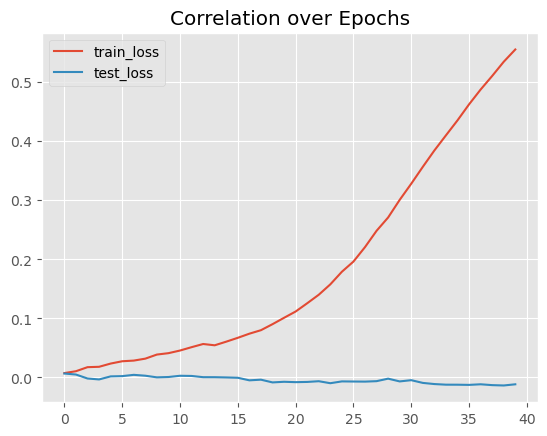

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:05<00:00,  1.64s/it]


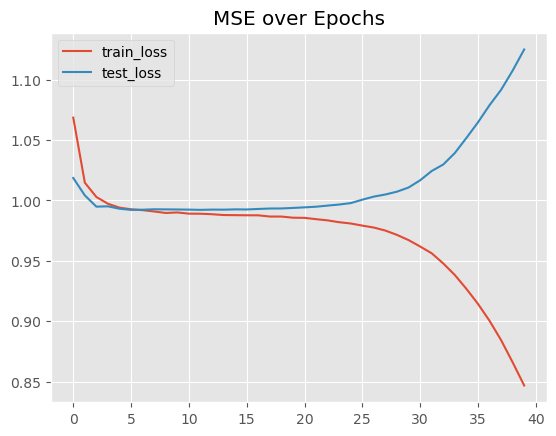

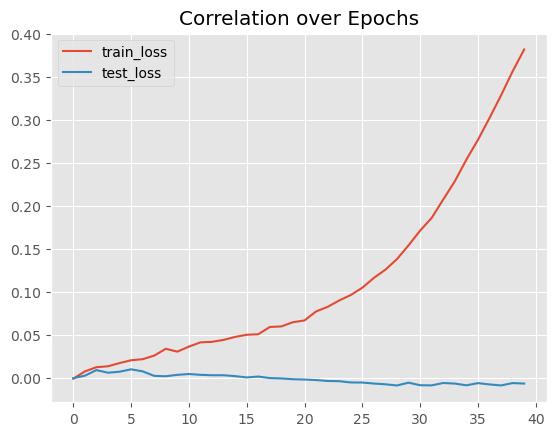

python(14626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14633) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(14636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [25]:
for c in [
    0.1, 
          0.05, 0.03, 
          0.01
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 10
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 1.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
        n_rolling: int = 5
    
    
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)

    
    mask = causal_mask
    mask = build_attention_mask(mask, Config.n_rolling, device=device)
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=True).to(device),
        'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
                                                                           roll_y=True).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/2, weight_decay=0)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=Config.n_rolling, roll_y=True, batch_size=256*2)
    
    if c < 0.05:
        epochs=40
    else:
        epochs=20
    
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=epochs)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))
    

### Time shift

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


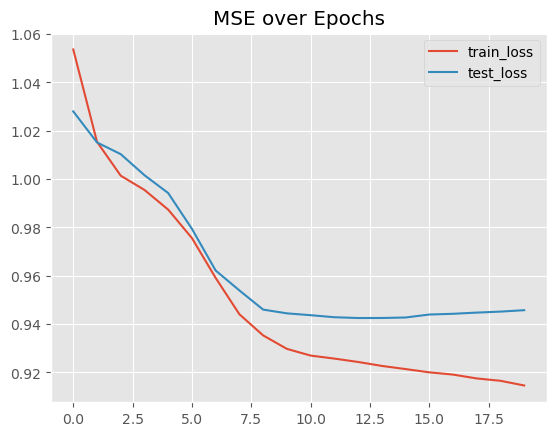

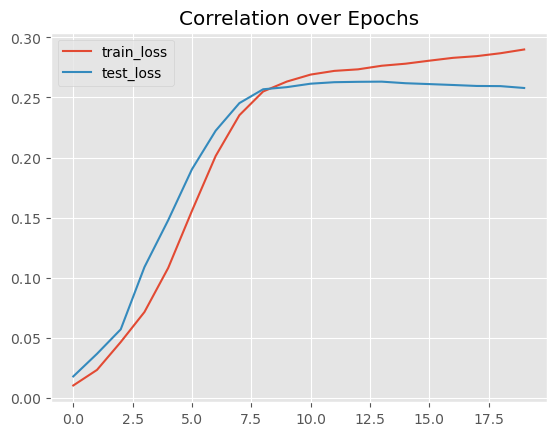

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


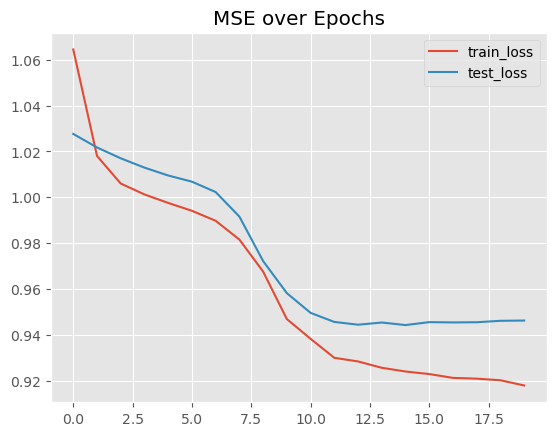

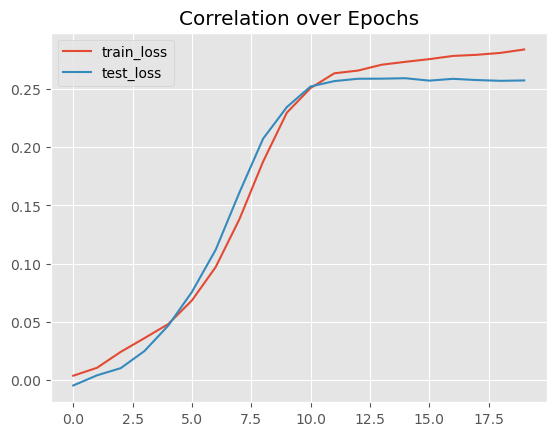

python(13623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(13631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13633) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.79s/it]


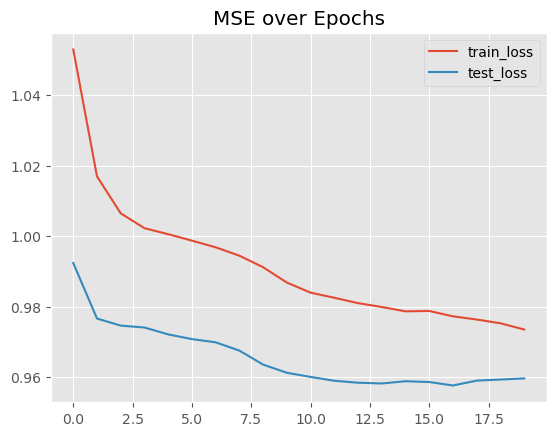

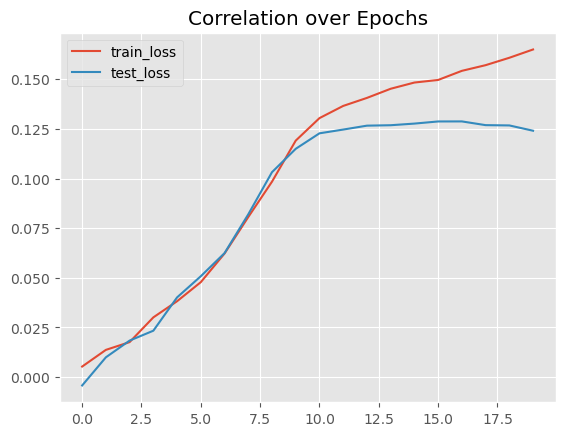

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.91s/it]


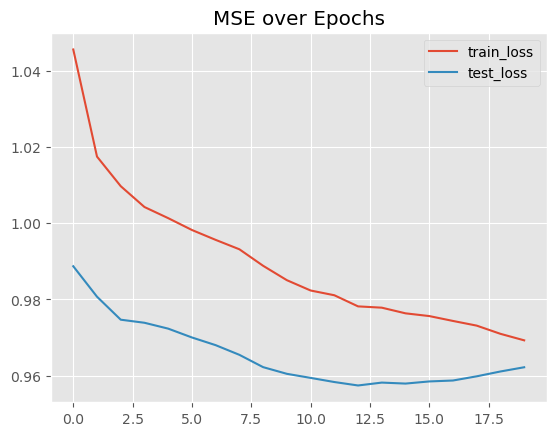

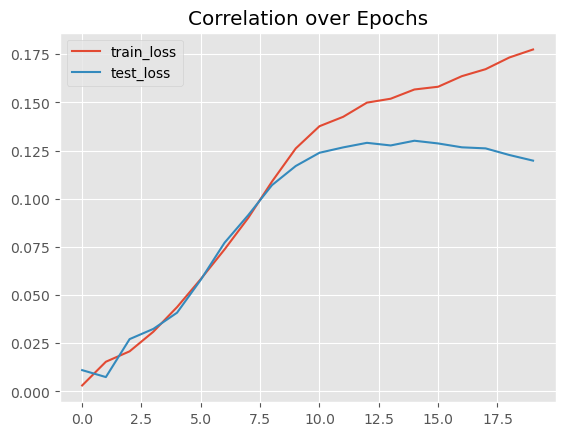

python(13675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(13688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:11<00:00,  1.79s/it]


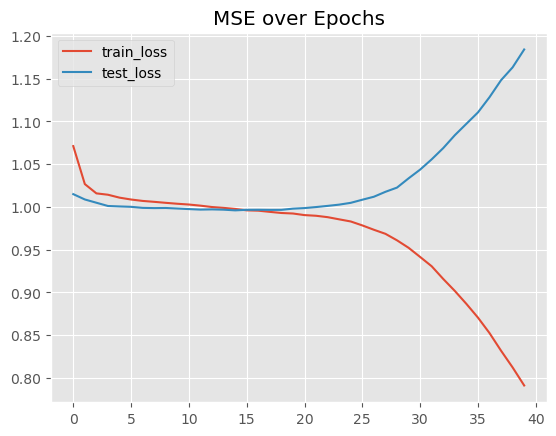

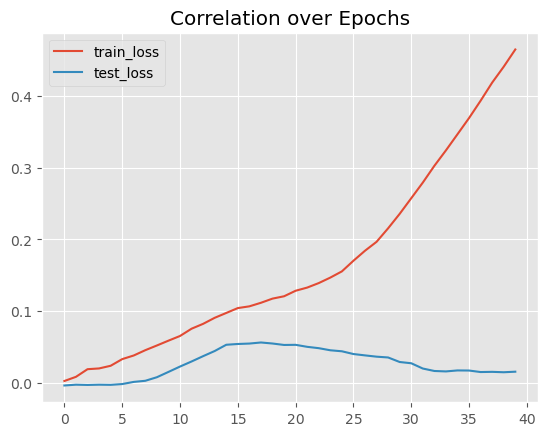

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:11<00:00,  1.78s/it]


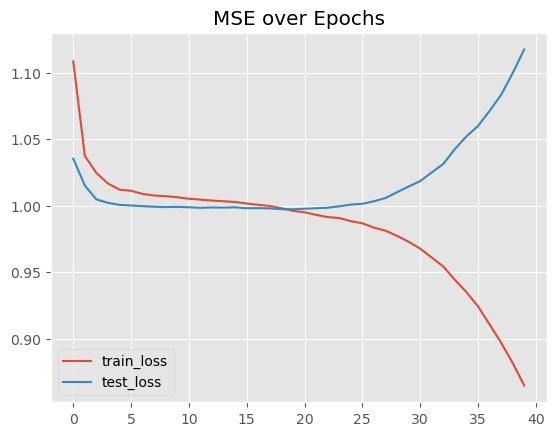

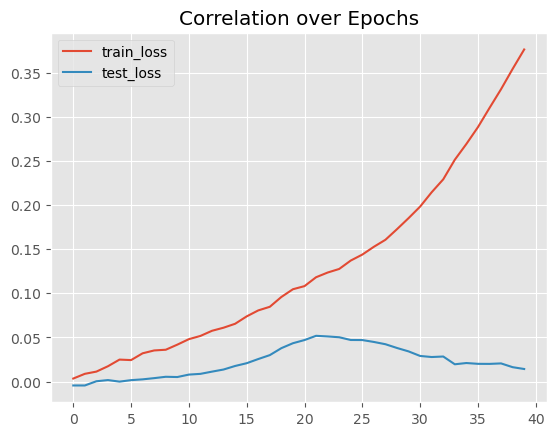

python(13785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(13796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:13<00:00,  3.34s/it]


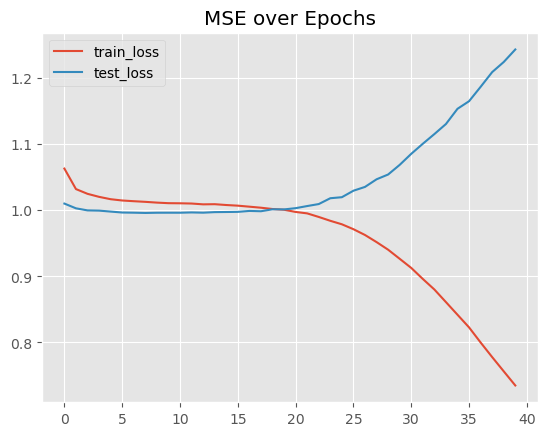

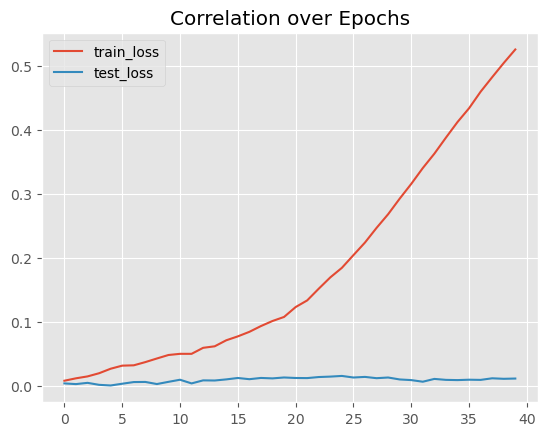

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:44<00:00,  2.62s/it]


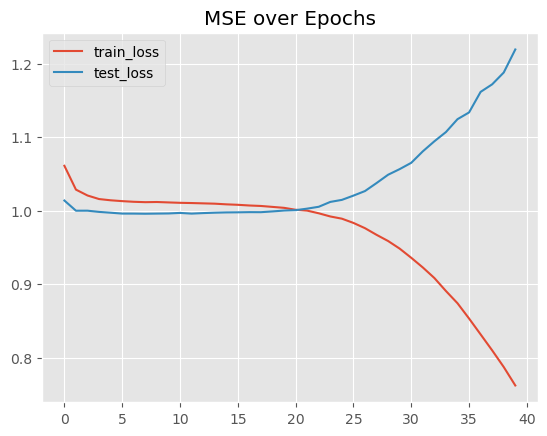

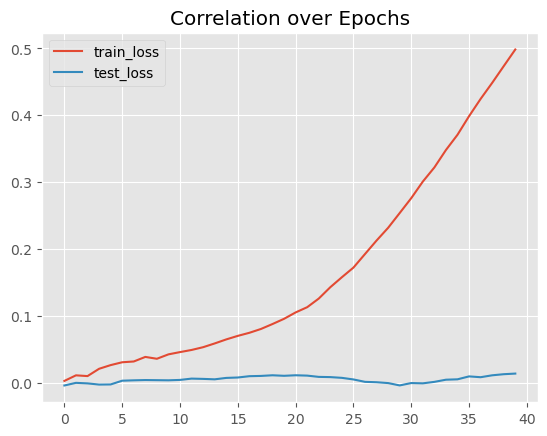

python(14038) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14039) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14046) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14048) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(14052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14053) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [22]:
for c in [
    0.1, 
          0.05, 
    0.03, 
          0.01
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 10
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 1.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
        n_rolling: int = 5
    
    
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)

    
    mask = causal_mask
    mask = build_attention_mask(mask, Config.n_rolling, device=device)
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=True).to(device),
        'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
                                                                           roll_y=True).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/2, weight_decay=0)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=Config.n_rolling, roll_y=True, batch_size=256*2)
    
    if c < 0.05:
        epochs=40
    else:
        epochs=20
    
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=epochs)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))

### CS + shift

For cs_shift roll_y=True doesn't work (probably the issue of the absolute vs relative embedding?) so I run everything without the roll_y

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:34<00:00,  1.58s/it]


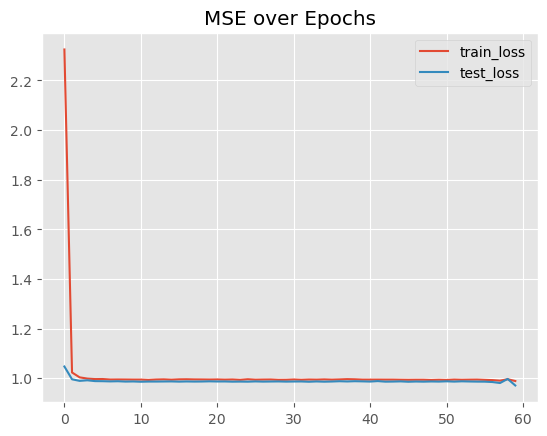

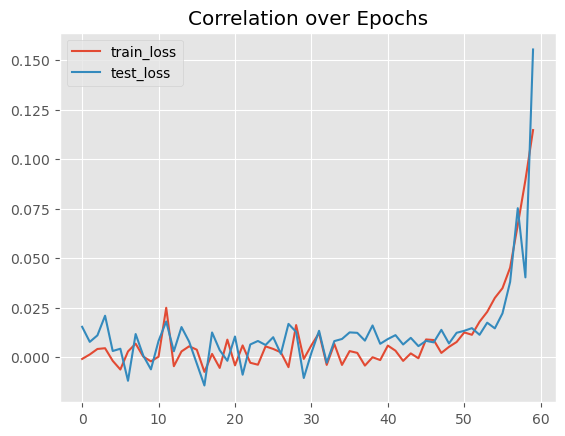

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:36<00:00,  1.61s/it]


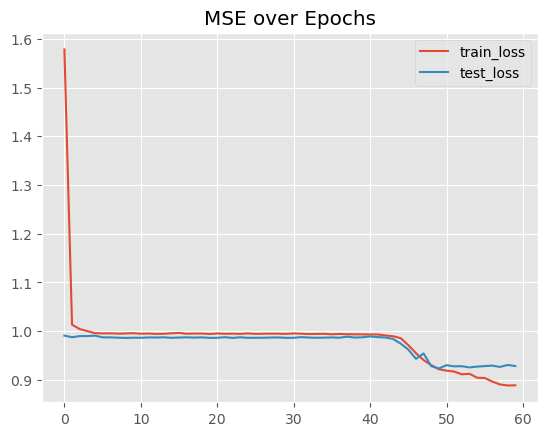

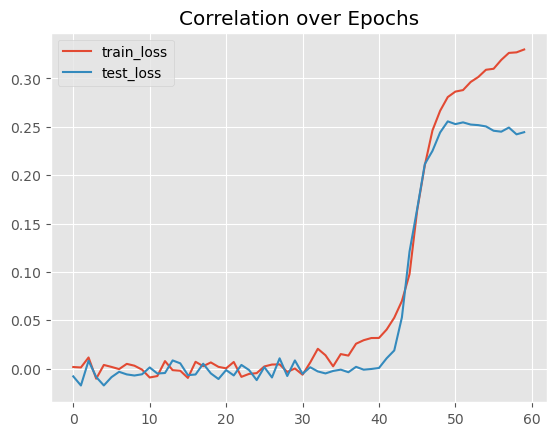

python(18378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18379) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18385) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18386) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18387) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(18398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18403) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:38<00:00,  1.65s/it]


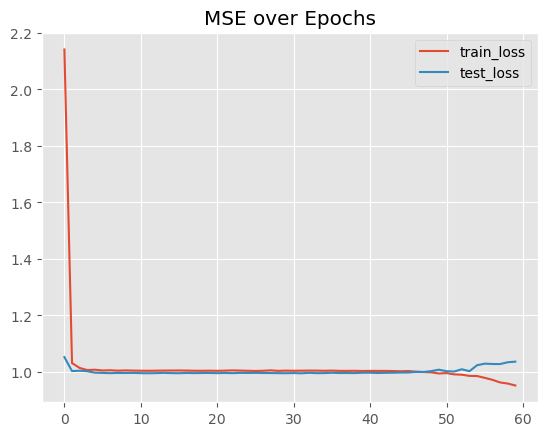

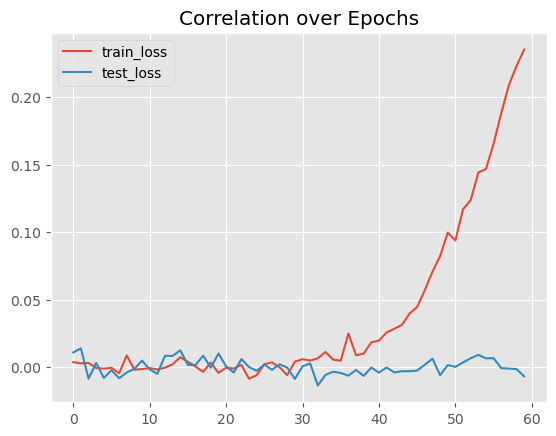

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:28<00:00,  1.48s/it]


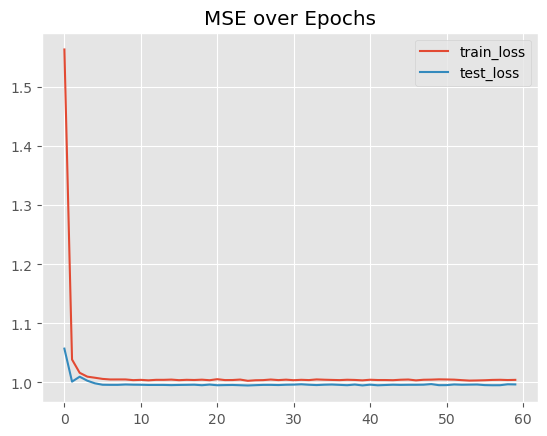

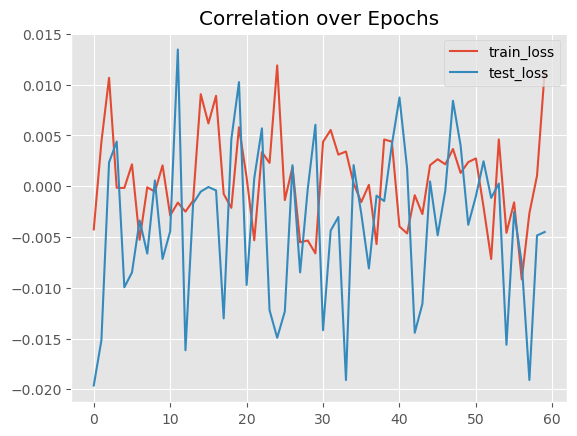

python(18537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(18550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18551) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18557) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18558) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:51<00:00,  1.60s/it]


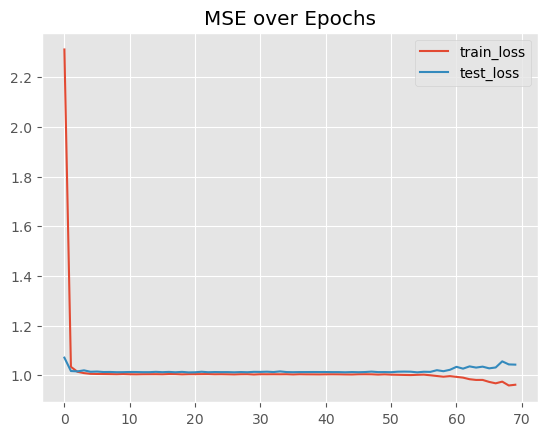

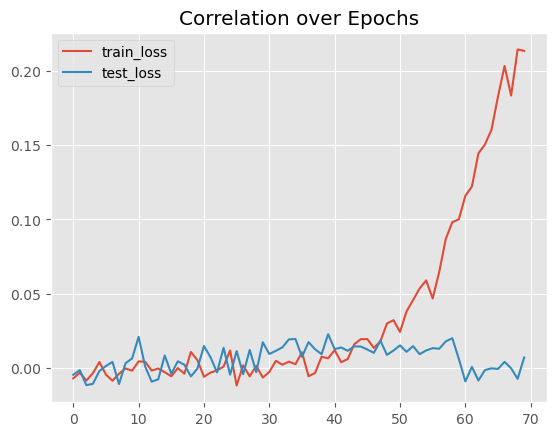

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:49<00:00,  1.56s/it]


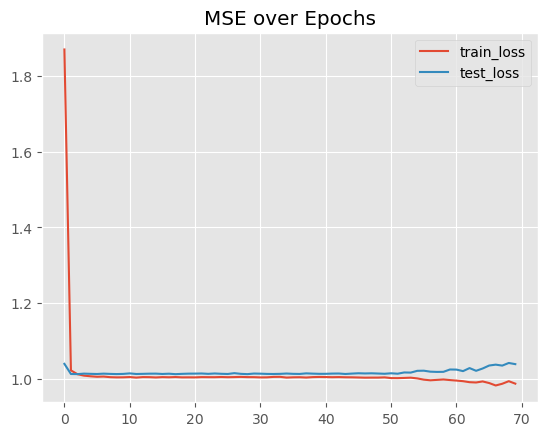

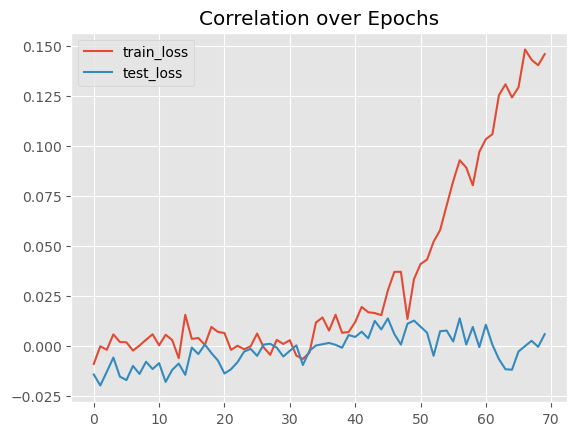

python(18631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18633) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(18649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [04:21<00:00,  3.74s/it]


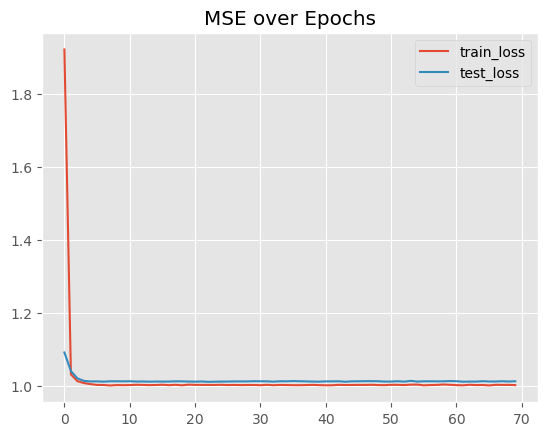

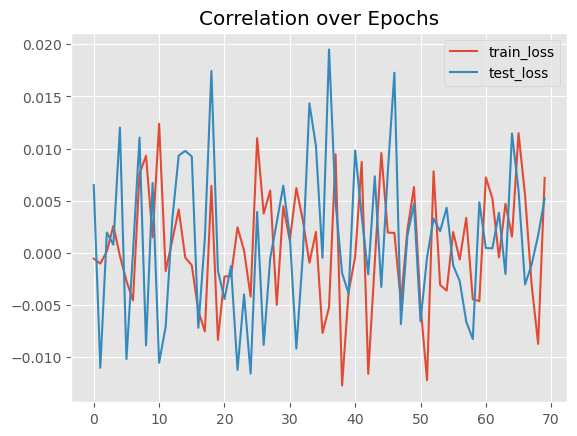

  0%|                                                                                                            | 0/70 [00:00<?, ?it/s]

In [ ]:
for c in [
    0.1, 
          0.05, 
    0.03, 
          0.01
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 10
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 1.0
        low_corr: float = c
        high_corr: float = c
        n_rolling: int = 5
    
    
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)

    
    mask = causal_mask
    mask = build_attention_mask(mask, Config.n_rolling, device=device)
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=False).to(device),
        'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
                                                                           roll_y=False).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=5e-3, weight_decay=1e-2)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=Config.n_rolling, roll_y=False, batch_size=256*2)
    
    if c < 0.05:
        epochs=70
    else:
        epochs=60
    
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=epochs)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))

### The 1% correlation

Last try of the noisy 1% cases without the roll_y

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [03:42<00:00,  2.02s/it]


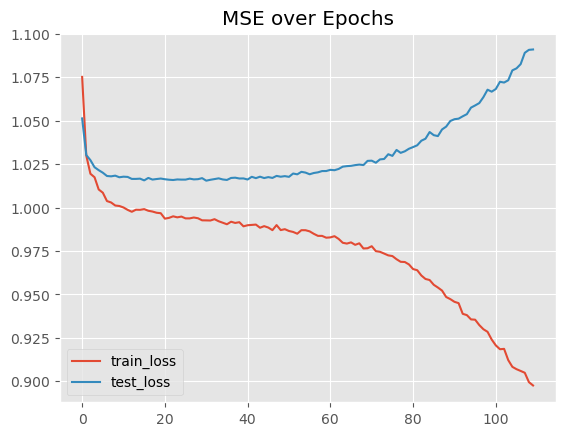

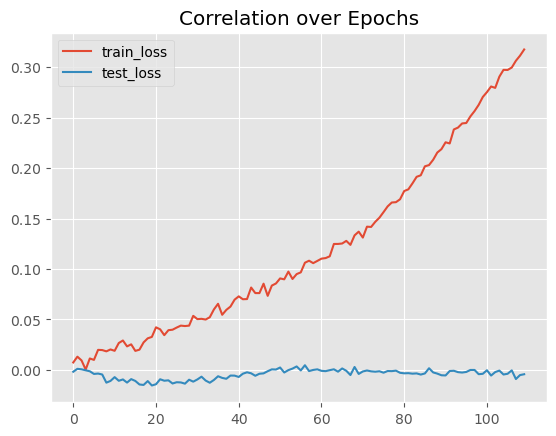

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:46<00:00,  1.51s/it]


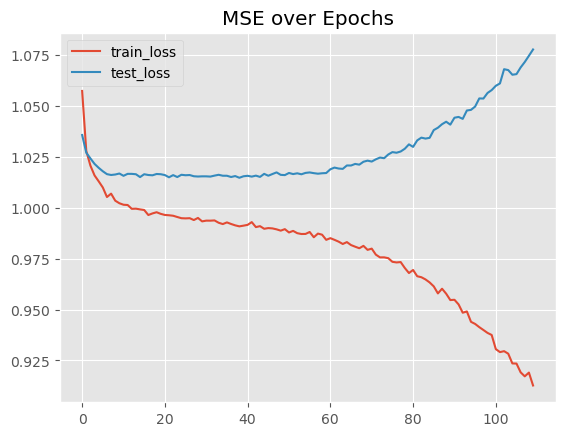

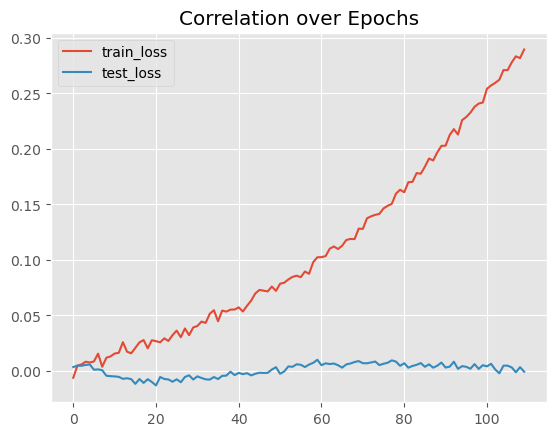

python(17546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17556) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17557) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17558) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [29]:
for c in [
    0.01, 
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 10
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 1.0
        split_seasonal: float = 0.0
        split_cs: float = 0.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
        n_rolling: int = 5
    
    
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)

    
    mask = causal_mask
    mask = build_attention_mask(mask, Config.n_rolling, device=device)
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=False).to(device),
        'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
                                                                           roll_y=False).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/10, weight_decay=0)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=Config.n_rolling, roll_y=False, batch_size=256*2)
    
    if c < 0.05:
        epochs=110
    else:
        epochs=90
    
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=epochs)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:46<00:00,  1.51s/it]


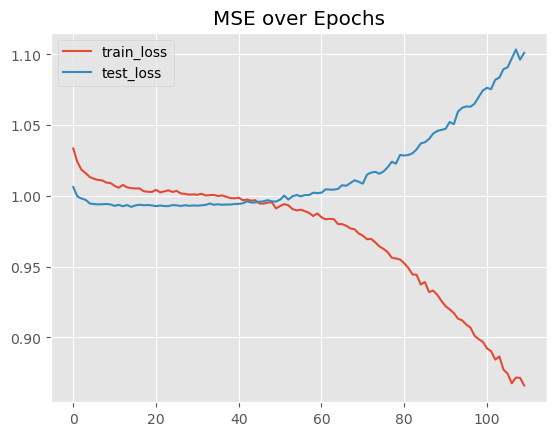

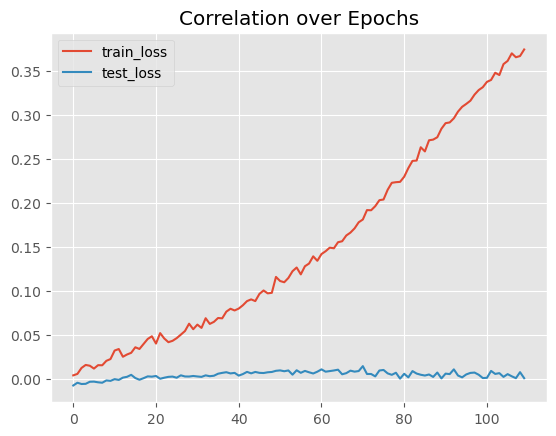

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:44<00:00,  1.50s/it]


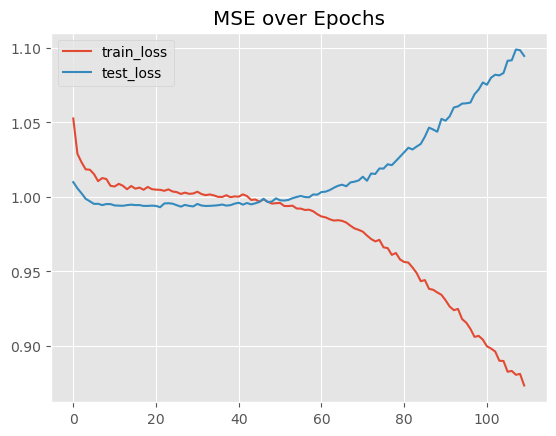

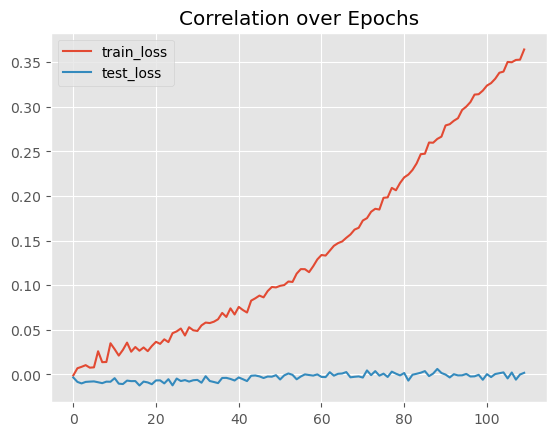

python(17666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [30]:
for c in [
    0.01, 
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 10
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.0
        split_shift: float = 0.0
        split_seasonal: float = 0.0
        split_cs: float = 1.0
        split_cs_shift: float = 0.0
        low_corr: float = c
        high_corr: float = c
        n_rolling: int = 5
    
    
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)

    
    mask = causal_mask
    mask = build_attention_mask(mask, Config.n_rolling, device=device)
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=False).to(device),
        'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
                                                                           roll_y=False).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/10, weight_decay=0)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=Config.n_rolling, roll_y=False, batch_size=256*2)
    
    if c < 0.05:
        epochs=110
    else:
        epochs=90
    
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=epochs)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))

### All effects

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.45s/it]


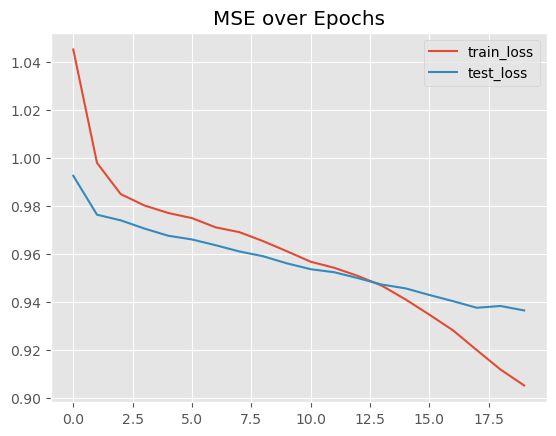

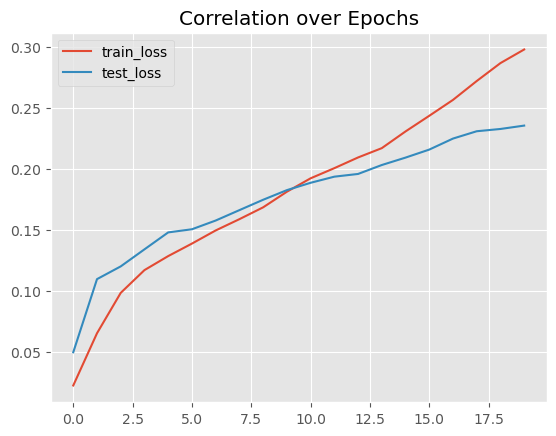

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]


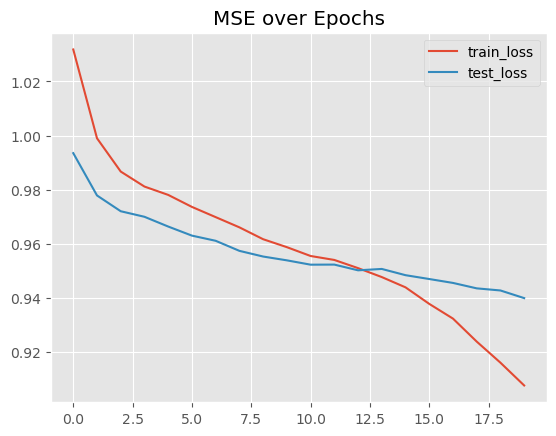

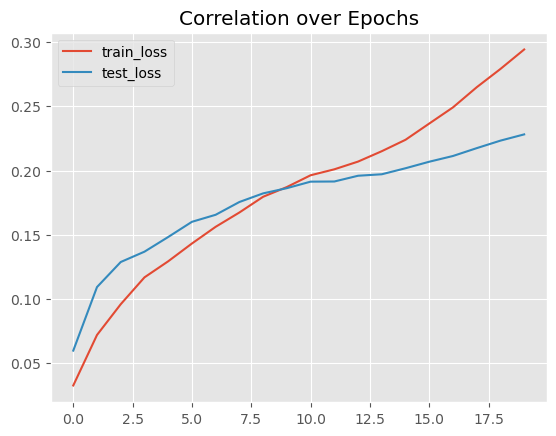

python(17697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17700) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17705) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17706) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


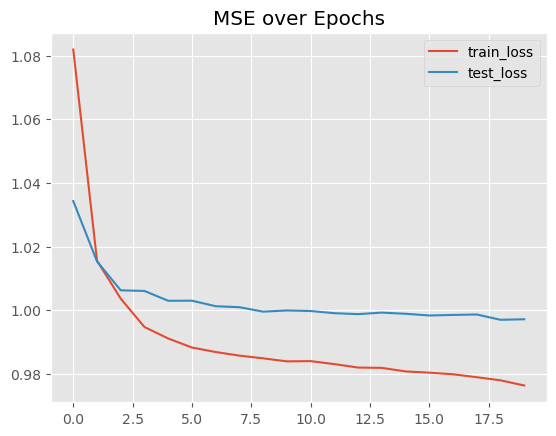

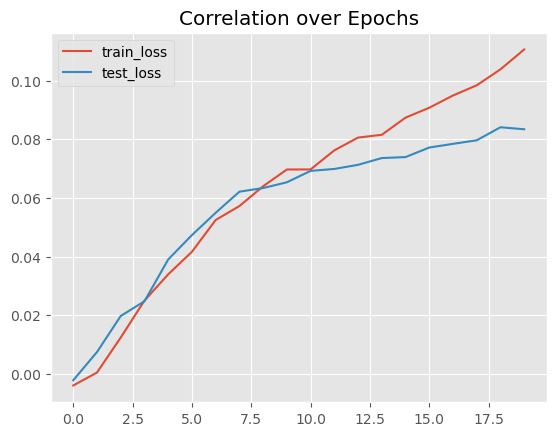

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


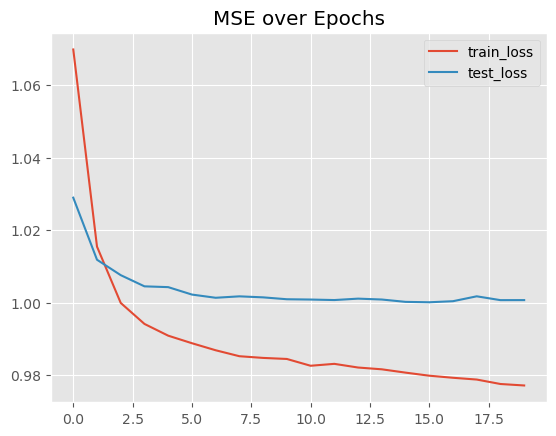

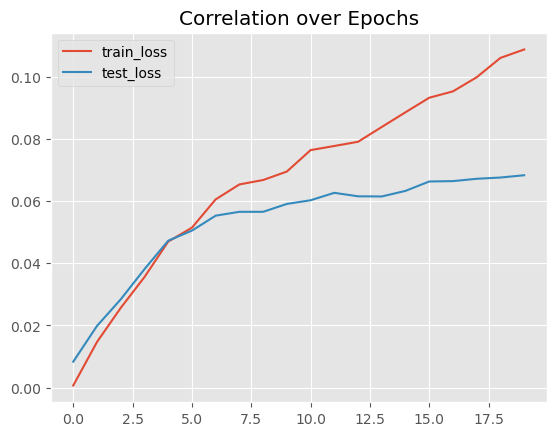

python(17753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17754) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17755) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17767) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:47<00:00,  1.58s/it]


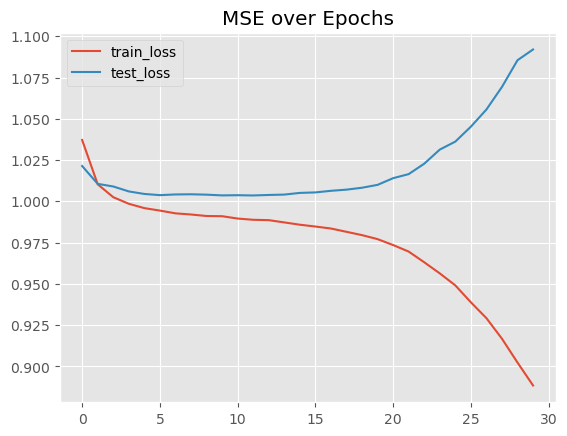

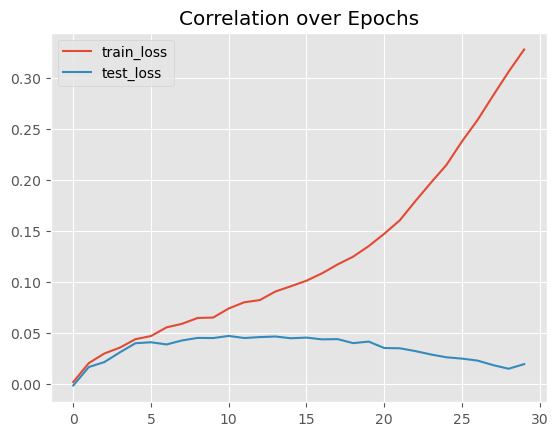

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:43<00:00,  1.46s/it]


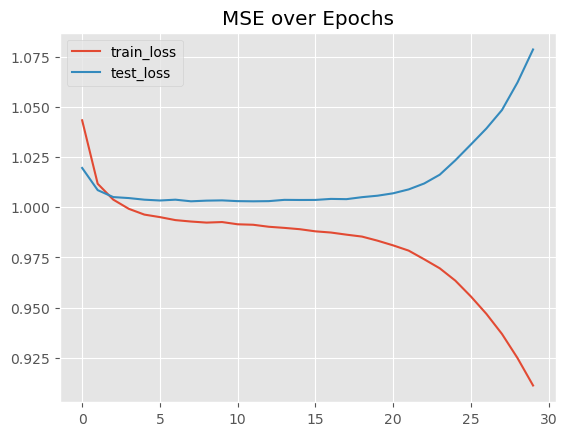

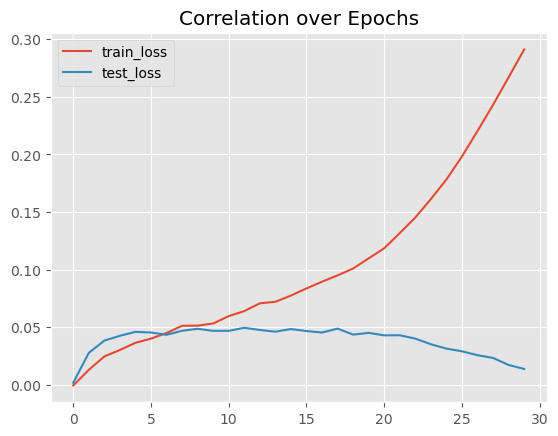

python(17785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:43<00:00,  1.44s/it]


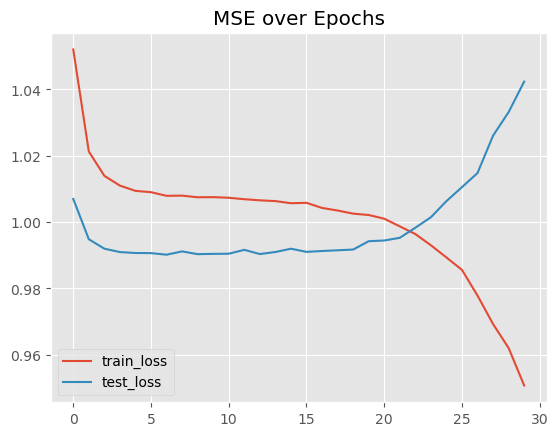

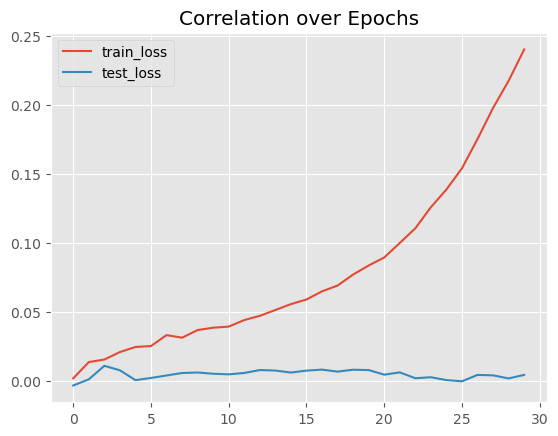

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:48<00:00,  1.60s/it]


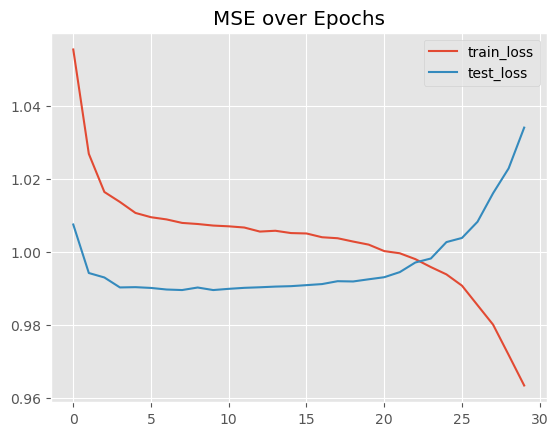

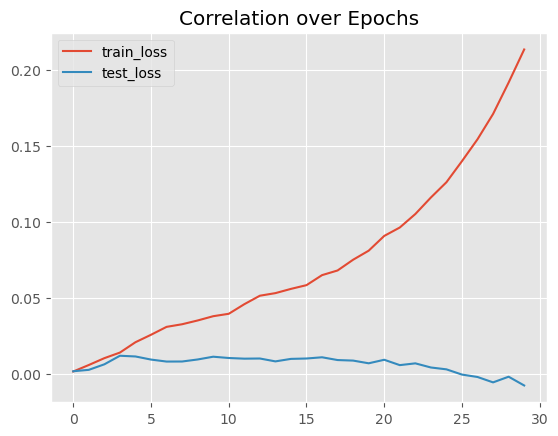

python(17841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17842) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17849) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [31]:
for c in [
    0.1, 
          0.05, 
    0.03, 
          0.01
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 10
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.2
        split_shift: float = 0.2
        split_seasonal: float = 0.0
        split_cs: float = 0.2
        split_cs_shift: float = 0.2
        low_corr: float = c
        high_corr: float = c
        n_rolling: int = 5
    
    
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)

    
    mask = causal_mask
    mask = build_attention_mask(mask, Config.n_rolling, device=device)
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=True).to(device),
        'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
                                                                           roll_y=True).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/2, weight_decay=0)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=Config.n_rolling, roll_y=True, batch_size=256*2)
    
    if c < 0.05:
        epochs=30
    else:
        epochs=20
    
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=epochs)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [02:13<00:00,  1.48s/it]


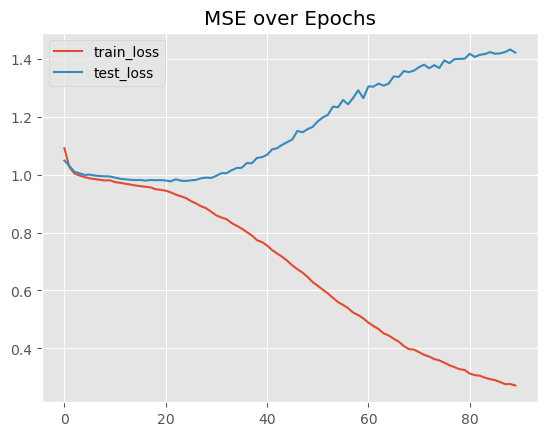

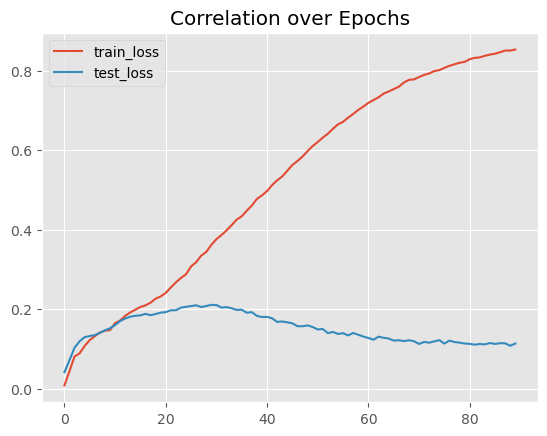

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [02:13<00:00,  1.48s/it]


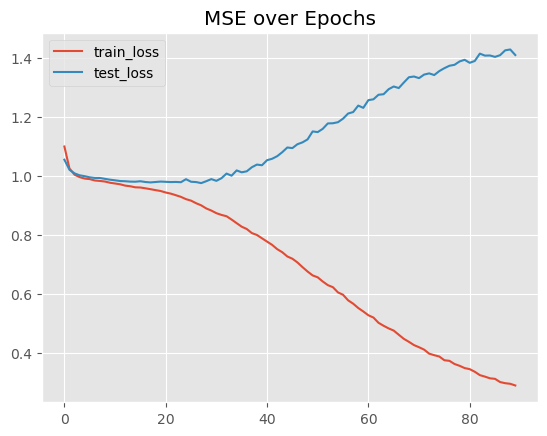

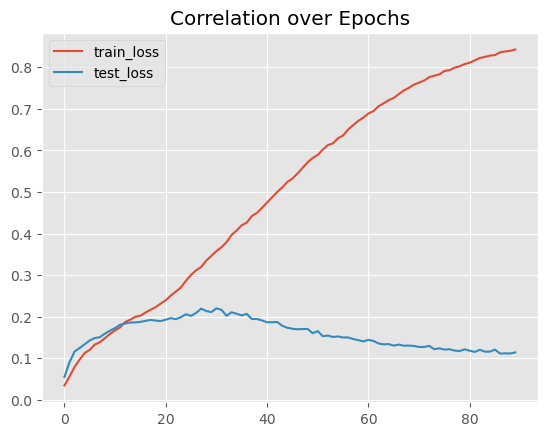

python(17909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [02:15<00:00,  1.51s/it]


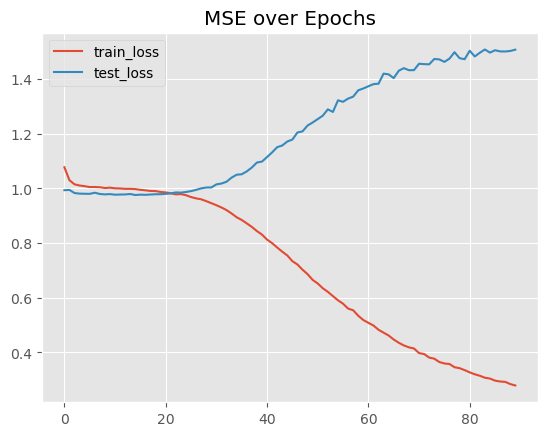

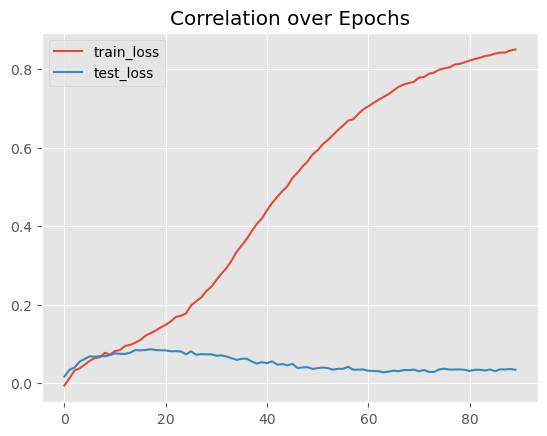

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [02:14<00:00,  1.50s/it]


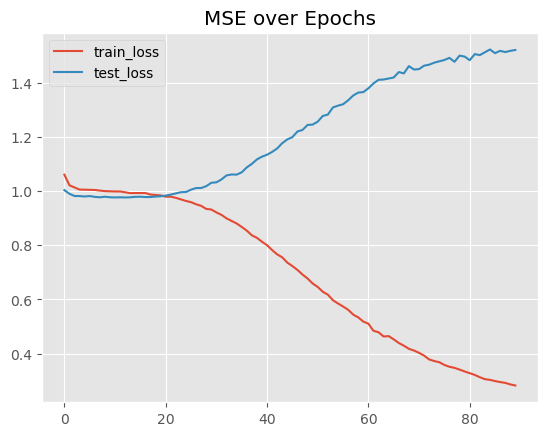

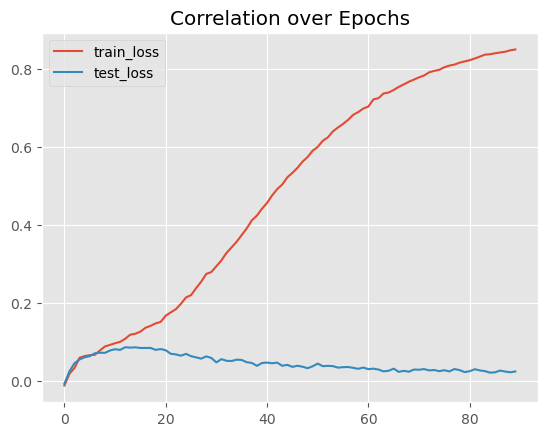

python(17962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(17970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17973) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17974) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17975) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17976) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17977) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:40<00:00,  1.46s/it]


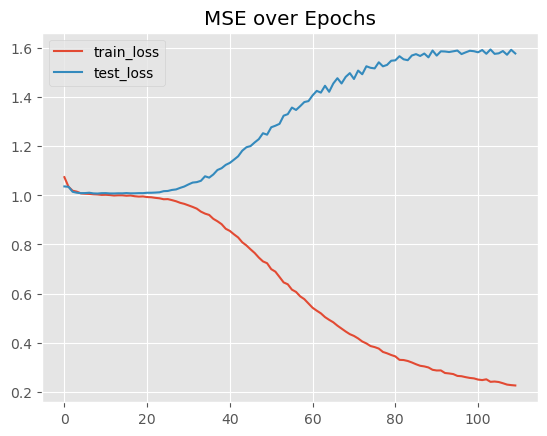

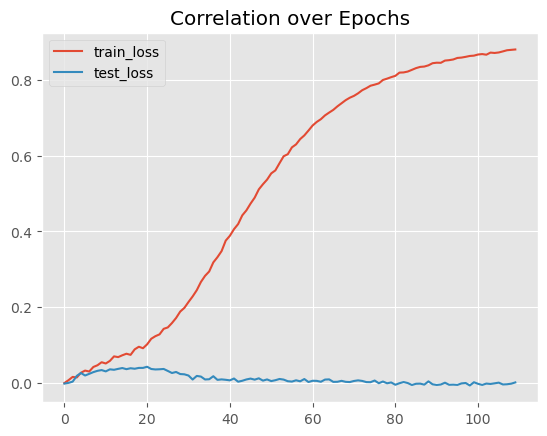

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:44<00:00,  1.49s/it]


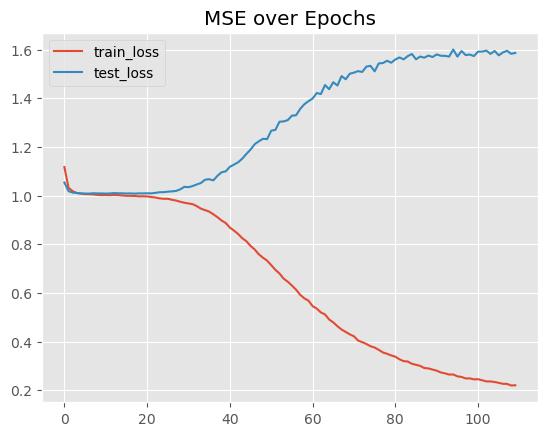

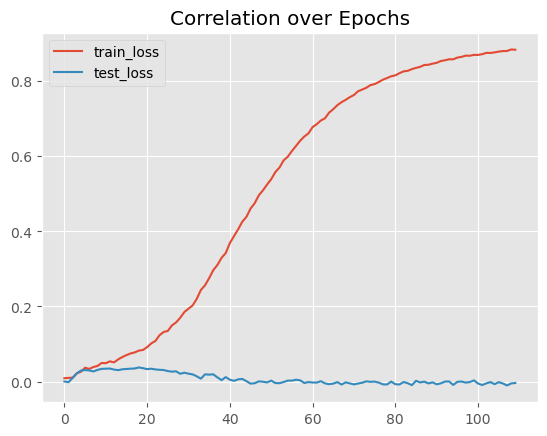

python(18049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18053) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(18068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18073) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18074) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [03:22<00:00,  1.84s/it]


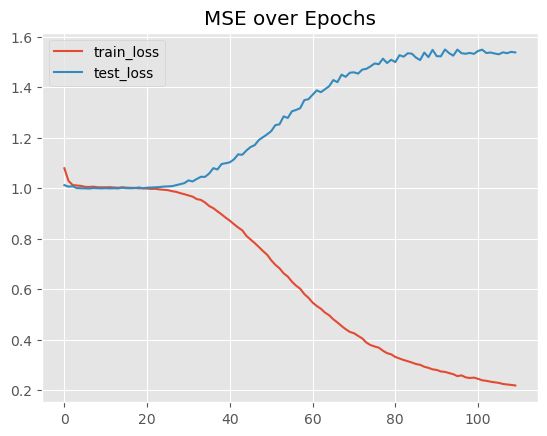

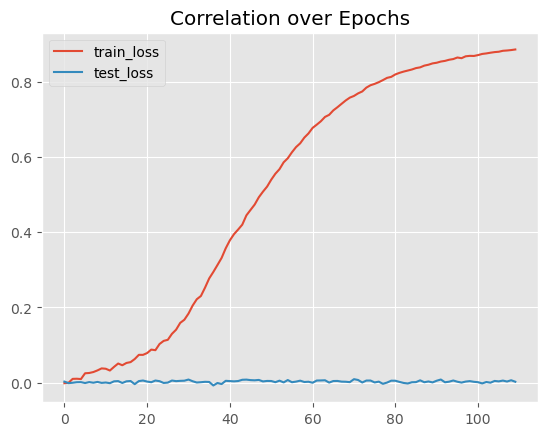

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:53<00:00,  1.58s/it]


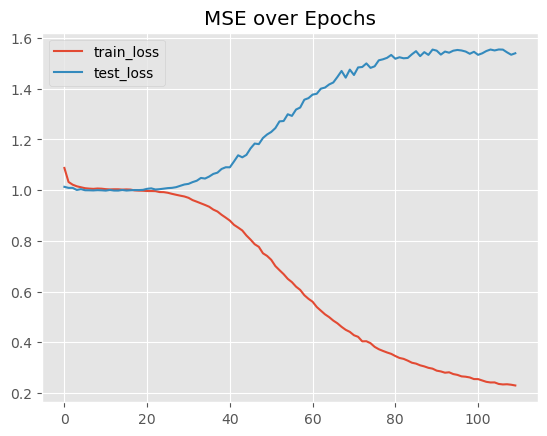

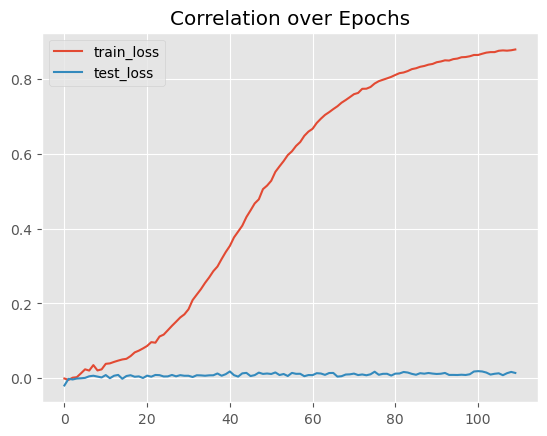

python(18236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(18244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [32]:
for c in [
    0.1, 
          0.05, 
    0.03, 
          0.01
]:
    @dataclass
    class Config:
        T: int = 5000
        n_ts: int = 10
        n_f: int = 20
        pct_zero_corr: float = 0.5
        split_conditional: float = 0.2
        split_shift: float = 0.2
        split_seasonal: float = 0.0
        split_cs: float = 0.2
        split_cs_shift: float = 0.2
        low_corr: float = c
        high_corr: float = c
        n_rolling: int = 5
    
    
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
    
    z.get_dataloader()
    for k in models_linear:
        models_linear[k].fit(z.train)

    
    mask = causal_mask
    mask = build_attention_mask(mask, Config.n_rolling, device=device)
    
    models_torch = {
          # 'temporal_transformer': models.OneDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, attn_direction='T',
          #                                                          dropout=0.5, num_mlp_layers=4, sparsify=None).to(device),
          # 'temporal_transformer_s': TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device),
          # 'dual_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, 10, mask=mask, layers='TC',
          #                                                           dropout=0.4, dim_feedforward=256, sparsify=None).to(device),
          # 'dual_transformer_s': DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device),
          'alternating_transformer': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=None, 
                                                                           roll_y=False).to(device),
        'alternating_transformer_s': models.CustomBiDimensionalTransformer(Config.n_ts, Config.n_f, Config.n_rolling, mask=mask, layers='TCTC',
                                                                    dropout=0.05, d_model=128, dim_feedforward=128*4, sparsify=keep_topk_per_row, 
                                                                           roll_y=False).to(device),
               }
    

    # optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)

    models_torch = {k: torch_benchmarks.TorchWrapper(models_torch[k], 
                                                     optimizer=torch.optim.AdamW(models_torch[k].parameters(), lr=1e-3/2, weight_decay=0)
                                                      # optimizer=torch.optim.SGD(models_torch[k].parameters(), lr=1e-1)
                                                    ) for k in models_torch}
    
    
    z.get_dataloader(n_rolling=Config.n_rolling, roll_y=False, batch_size=256*2)
    
    if c < 0.05:
        epochs=110
    else:
        epochs=90
    
    for k in models_torch:
        models_torch[k].fit(z.train, test=z.test, epochs=epochs)
    
    
    comp = benchmark_comparison.Comparator(models=[models_linear[k] for k in models_linear] + [models_torch[k] for k in models_torch], 
                                           model_names=[k for k in models_linear] + [k for k in models_torch])
    display(comp.correl(z, mode='train'))
    display(comp.correl(z, mode='test'))